# Example of using the Borehole3D class

## Imports

In [1]:
from striplog import Component, Decor, Legend, Lexicon, Striplog
from core.omf import Borehole3D, striplog_legend_to_omf_legend 
from utils.lexicon import Lexicon_FR_updated as lexicon_fr
from utils.io import boreholes_from_files, striplog_from_text,gdf_viewer,\
df_from_sources, striplog_from_df
from core.core import Project
from core.orm import BoreholeOrm, PositionOrm, Base 

import matplotlib.pyplot as plt
from os import remove
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from definitions import ROOT_DIR

## Reading of CSV files in a dir

In [2]:
df = pd.read_csv('test_data_boreholes.csv', sep=',')

## Data Checking

In [3]:
df.drop('Z', axis='columns', inplace=True)
df.rename({'new_Z':'Z'}, axis='columns', inplace=True)

In [4]:
df.loc[df.query('Colour=="tan"').index, 'Colour'] = 'green' # use simple colour

In [5]:
df[:10]

,ID,X,Y,Z,Diameter,Length,Lithology,Colour,Thickness,Top_litho,Base_litho
0,BH001,152600.0,121039.0,101.0,0.43,39,sand,gainsboro,4,0,4
1,BH001,152600.0,121039.0,97.0,0.43,39,clay,green,4,4,8
2,BH001,152600.0,121039.0,93.0,0.43,39,sandstone,forestgreen,12,8,20
3,BH001,152600.0,121039.0,81.0,0.43,39,coal,antiquewhite,8,20,28
4,BH001,152600.0,121039.0,73.0,0.43,39,limestone,darkslategrey,11,28,39
5,BH002,152819.0,121586.0,103.0,0.60,37,sand,gainsboro,5,0,5
6,BH002,152819.0,121586.0,98.0,0.60,37,clay,green,3,5,8
7,BH002,152819.0,121586.0,95.0,0.60,37,sandstone,forestgreen,6,8,14
8,BH002,152819.0,121586.0,89.0,0.60,37,coal,antiquewhite,1,14,15
9,BH002,152819.0,121586.0,88.0,0.60,37,limestone,darkslategrey,22,15,37


In [6]:
df.query('X==152013.0 and Y==121905.0')

,ID,X,Y,Z,Diameter,Length,Lithology,Colour,Thickness,Top_litho,Base_litho
850,BH171,152013.0,121905.0,101.0,0.56,17,sand,gainsboro,2,0,2
851,BH171,152013.0,121905.0,99.0,0.56,17,clay,green,3,2,5
852,BH171,152013.0,121905.0,96.0,0.56,17,sandstone,forestgreen,6,5,11
853,BH171,152013.0,121905.0,90.0,0.56,17,coal,antiquewhite,3,11,14
854,BH171,152013.0,121905.0,87.0,0.56,17,limestone,darkslategrey,3,14,17


## Create Boreholes from dataframes or files

In [7]:
bhs_df=[df] # list of dataframes

In [8]:
boreholes, components, link_intv_comp = boreholes_from_files(bhs_df, verbose=True,
                                                litho_field='Lithology',
                                                color_field='Colour',
                                                lexicon='en', #Lexicon.default(),
                                            diam_field='Diameter', 
                                            thick_field='Thickness')


Dataframe 0 processing...
|__ID:'BH001'
Error : No lithology matching with 'coal antiquewhite' in given lexicon
Summary : [Striplog(5 Intervals, start=0.0, stop=39.0)]
{0: {'description': 'sand gainsboro', 'interval_number': 0, 'top': <core.orm.PositionOrm object at 0x7f669ab8adf0>, 'base': <core.orm.PositionOrm object at 0x7f669abf6580>}, 1: {'description': 'clay green', 'interval_number': 1, 'top': <core.orm.PositionOrm object at 0x7f669ab48400>, 'base': <core.orm.PositionOrm object at 0x7f669ab48340>}, 2: {'description': 'sandstone forestgreen', 'interval_number': 2, 'top': <core.orm.PositionOrm object at 0x7f669ab481c0>, 'base': <core.orm.PositionOrm object at 0x7f669ab482e0>}, 3: {'description': 'white sand', 'interval_number': 3, 'top': <core.orm.PositionOrm object at 0x7f669ab48250>, 'base': <core.orm.PositionOrm object at 0x7f669ab484c0>}, 4: {'description': 'limestone darkslategrey', 'interval_number': 4, 'top': <core.orm.PositionOrm object at 0x7f669ab483d0>, 'base': <core.o

/home/yanathan/Projects/GSDMA/utils/io.py:518: SAWarning: relationship 'ComponentOrm.intervals' will copy column Components.id to column Linkintervalcomponent.comp_id, which conflicts with relationship(s): 'IntervalOrm.components' (copies Components.id to Linkintervalcomponent.comp_id). If this is not the intention, consider if these relationships should be linked with back_populates, or if viewonly=True should be applied to one or more if they are read-only. For the less common case that foreign key constraints are partially overlapping, the orm.foreign() annotation can be used to isolate the columns that should be written towards.   The 'overlaps' parameter may be used to remove this warning.
  boreholes.append(BoreholeOrm(id=id_))
/home/yanathan/Projects/GSDMA/utils/io.py:518: SAWarning: relationship 'ComponentOrm.intervals' will copy column Intervals.id to column Linkintervalcomponent.int_id, which conflicts with relationship(s): 'IntervalOrm.components' (copies Intervals.id to Lin


{150: {'description': 'sand gainsboro', 'interval_number': 0, 'top': <core.orm.PositionOrm object at 0x7f669aa97b50>, 'base': <core.orm.PositionOrm object at 0x7f669aa97c40>}, 151: {'description': 'clay green', 'interval_number': 1, 'top': <core.orm.PositionOrm object at 0x7f669aa979a0>, 'base': <core.orm.PositionOrm object at 0x7f669aa97e20>}, 152: {'description': 'sandstone forestgreen', 'interval_number': 2, 'top': <core.orm.PositionOrm object at 0x7f669aa97580>, 'base': <core.orm.PositionOrm object at 0x7f669aa973a0>}, 153: {'description': 'white sand', 'interval_number': 3, 'top': <core.orm.PositionOrm object at 0x7f669aa97bb0>, 'base': <core.orm.PositionOrm object at 0x7f669aa97880>}, 154: {'description': 'limestone darkslategrey', 'interval_number': 4, 'top': <core.orm.PositionOrm object at 0x7f669aa97a90>, 'base': <core.orm.PositionOrm object at 0x7f669aa97df0>}}

|__ID:'BH032'
Error : No lithology matching with 'coal antiquewhite' in given lexicon
Summary : [Striplog(5 Interv

Summary : [Striplog(5 Intervals, start=0.0, stop=23.0)]
{345: {'description': 'sand gainsboro', 'interval_number': 0, 'top': <core.orm.PositionOrm object at 0x7f669a942c40>, 'base': <core.orm.PositionOrm object at 0x7f669a942b80>}, 346: {'description': 'clay green', 'interval_number': 1, 'top': <core.orm.PositionOrm object at 0x7f669a942b20>, 'base': <core.orm.PositionOrm object at 0x7f669a942ac0>}, 347: {'description': 'sandstone forestgreen', 'interval_number': 2, 'top': <core.orm.PositionOrm object at 0x7f669a942c70>, 'base': <core.orm.PositionOrm object at 0x7f669a942e50>}, 348: {'description': 'white sand', 'interval_number': 3, 'top': <core.orm.PositionOrm object at 0x7f669a942dc0>, 'base': <core.orm.PositionOrm object at 0x7f669a942d00>}, 349: {'description': 'limestone darkslategrey', 'interval_number': 4, 'top': <core.orm.PositionOrm object at 0x7f669aa2e790>, 'base': <core.orm.PositionOrm object at 0x7f669a942f70>}}

|__ID:'BH071'
Error : No lithology matching with 'coal anti

|__ID:'BH109'
Error : No lithology matching with 'coal antiquewhite' in given lexicon
Summary : [Striplog(5 Intervals, start=0.0, stop=32.0)]
{540: {'description': 'sand gainsboro', 'interval_number': 0, 'top': <core.orm.PositionOrm object at 0x7f669a853c40>, 'base': <core.orm.PositionOrm object at 0x7f669a853850>}, 541: {'description': 'clay green', 'interval_number': 1, 'top': <core.orm.PositionOrm object at 0x7f669a853a30>, 'base': <core.orm.PositionOrm object at 0x7f669a8539a0>}, 542: {'description': 'sandstone forestgreen', 'interval_number': 2, 'top': <core.orm.PositionOrm object at 0x7f669a853820>, 'base': <core.orm.PositionOrm object at 0x7f669a853a60>}, 543: {'description': 'white sand', 'interval_number': 3, 'top': <core.orm.PositionOrm object at 0x7f669a853af0>, 'base': <core.orm.PositionOrm object at 0x7f669a853b20>}, 544: {'description': 'limestone darkslategrey', 'interval_number': 4, 'top': <core.orm.PositionOrm object at 0x7f669a853e80>, 'base': <core.orm.PositionOrm ob

|__ID:'BH145'
Error : No lithology matching with 'coal antiquewhite' in given lexicon
Summary : [Striplog(5 Intervals, start=0.0, stop=28.0)]
{720: {'description': 'sand gainsboro', 'interval_number': 0, 'top': <core.orm.PositionOrm object at 0x7f6698788880>, 'base': <core.orm.PositionOrm object at 0x7f66987aff70>}, 721: {'description': 'clay green', 'interval_number': 1, 'top': <core.orm.PositionOrm object at 0x7f66987af280>, 'base': <core.orm.PositionOrm object at 0x7f66987af340>}, 722: {'description': 'sandstone forestgreen', 'interval_number': 2, 'top': <core.orm.PositionOrm object at 0x7f669873fdc0>, 'base': <core.orm.PositionOrm object at 0x7f669873f1f0>}, 723: {'description': 'white sand', 'interval_number': 3, 'top': <core.orm.PositionOrm object at 0x7f669873f2e0>, 'base': <core.orm.PositionOrm object at 0x7f669873fac0>}, 724: {'description': 'limestone darkslategrey', 'interval_number': 4, 'top': <core.orm.PositionOrm object at 0x7f669873f760>, 'base': <core.orm.PositionOrm ob

|__ID:'BH172'
Error : No lithology matching with 'coal antiquewhite' in given lexicon
Summary : [Striplog(5 Intervals, start=0.0, stop=12.0)]
{855: {'description': 'sand gainsboro', 'interval_number': 0, 'top': <core.orm.PositionOrm object at 0x7f669aa11af0>, 'base': <core.orm.PositionOrm object at 0x7f669aa118e0>}, 856: {'description': 'clay green', 'interval_number': 1, 'top': <core.orm.PositionOrm object at 0x7f669aa11820>, 'base': <core.orm.PositionOrm object at 0x7f669aa11580>}, 857: {'description': 'sandstone forestgreen', 'interval_number': 2, 'top': <core.orm.PositionOrm object at 0x7f669aa11be0>, 'base': <core.orm.PositionOrm object at 0x7f669aa11ac0>}, 858: {'description': 'white sand', 'interval_number': 3, 'top': <core.orm.PositionOrm object at 0x7f669aa11e20>, 'base': <core.orm.PositionOrm object at 0x7f669aa2e0a0>}, 859: {'description': 'limestone darkslategrey', 'interval_number': 4, 'top': <core.orm.PositionOrm object at 0x7f669aa2efa0>, 'base': <core.orm.PositionOrm ob

In [9]:
boreholes[170].intervals[850].top.x, boreholes[170].intervals[850].top.y

(152925.0, 121815.0)

In [10]:
boreholes

[<core.orm.BoreholeOrm>(Name=BH001, Length=39, Diameter=0.43, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH002, Length=37, Diameter=0.6, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH003, Length=18, Diameter=0.41, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH004, Length=26, Diameter=0.61, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH005, Length=29, Diameter=0.61, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH006, Length=26, Diameter=0.31, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH007, Length=41, Diameter=0.57, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH008, Length=35, Diameter=0.39, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH009, Length=40, Diameter=0.5, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH10, Length=31, Diameter=0.31, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH011, Length=30, Diameter=0.31, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH012, Length=41, Diameter=0.54, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH013, Length=29, Diameter=0.36, Intervals=5),
 <core.orm.Bore

In [11]:
components

{0: Component({'lithology': 'sandstone'}),
 1: Component({'lithology': 'limestone'}),
 2: Component({'lithology': 'sand', 'colour': 'white'}),
 3: Component({'lithology': 'sand'}),
 4: Component({'lithology': 'clay', 'colour': 'green'})}

In [12]:
len(boreholes), len(components)

(199, 5)

## Create a project and save data in a database

In [13]:
remove('tmp_files/tfe_orm_db.db')

In [14]:
engine = create_engine('sqlite:///tmp_files/tfe_orm_db.db', echo=True)

In [15]:
Base.metadata.create_all(engine)

2021-06-09 15:21:09,093 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-09 15:21:09,094 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("Boreholes")
2021-06-09 15:21:09,094 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-06-09 15:21:09,096 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("Boreholes")
2021-06-09 15:21:09,096 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-06-09 15:21:09,097 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("Positions")
2021-06-09 15:21:09,098 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-06-09 15:21:09,099 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("Positions")
2021-06-09 15:21:09,099 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-06-09 15:21:09,100 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("Intervals")
2021-06-09 15:21:09,100 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-06-09 15:21:09,100 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("Intervals")
2021-06-09 15:21:09,101 INFO sqlalchemy.engine.Engine 

In [16]:
Session = sessionmaker(bind=engine)
session = Session()

In [17]:
p = Project(session)
p.add_components(components)

2021-06-09 15:21:09,146 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-09 15:21:09,149 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-09 15:21:09,149 INFO sqlalchemy.engine.Engine [generated in 0.00091s] ()
None
2021-06-09 15:21:09,153 INFO sqlalchemy.engine.Engine INSERT INTO "Components" (id, description) VALUES (?, ?)
2021-06-09 15:21:09,154 INFO sqlalchemy.engine.Engine [generated in 0.00088s] ((0, 'Sandstone'), (1, 'Limestone'), (2, 'Sand, white'), (3, 'Sand'), (4, 'Clay, green'))
2021-06-09 15:21:09,156 INFO sqlalchemy.engine.Engine COMMIT
2021-06-09 15:21:09,159 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-09 15:21:09,160 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-09 15:21:09,160 INFO sql

Add boreholes into the project

In [18]:
for bh in boreholes:
    p.add_borehole(bh)

2021-06-09 15:21:09,166 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-06-09 15:21:09,167 INFO sqlalchemy.engine.Engine [generated in 0.00083s] ('BH001', 39.0, 0.43)
2021-06-09 15:21:09,169 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-06-09 15:21:09,170 INFO sqlalchemy.engine.Engine [generated in 0.00116s] ((0, 0.0, 0.0, 0.0, 152600.0, 121039.0), (1, 4.0, 4.0, 4.0, 152600.0, 121039.0), (2, 4.0, 4.0, 4.0, 152600.0, 121039.0), (3, 8.0, 8.0, 8.0, 152600.0, 121039.0), (4, 8.0, 8.0, 8.0, 152600.0, 121039.0), (5, 20.0, 20.0, 20.0, 152600.0, 121039.0), (6, 20.0, 20.0, 20.0, 152600.0, 121039.0), (7, 28.0, 28.0, 28.0, 152600.0, 121039.0), (8, 28.0, 28.0, 28.0, 152600.0, 121039.0), (9, 39.0, 39.0, 39.0, 152600.0, 121039.0))
2021-06-09 15:21:09,173 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, 

None
2021-06-09 15:21:09,263 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-09 15:21:09,263 INFO sqlalchemy.engine.Engine [cached since 0.07619s ago] ('BH002',)
2021-06-09 15:21:09,266 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:09,266 INFO sqlalchemy.engine.Engine [cached since 0.0757s ago] (10,)
2021-06-09 15:21:09,269 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positio

2021-06-09 15:21:09,359 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:09,359 INFO sqlalchemy.engine.Engine [cached since 0.1656s ago] (23,)
2021-06-09 15:21:09,360 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:09,361 INFO sqlalchemy.engine.Engine [cached since 0.1703s ago] (24,)
2021-06-09 15:21:09,362 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "

2021-06-09 15:21:09,441 INFO sqlalchemy.engine.Engine [cached since 0.248s ago] (37,)
2021-06-09 15:21:09,443 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:09,444 INFO sqlalchemy.engine.Engine [cached since 0.2528s ago] (38,)
2021-06-09 15:21:09,445 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:09,445 INFO sqlalchemy.engine.Engine [cached since 0.2519s ago] (39,)
No given legend or incorrect format ! A default one is used
True
Borehole geometry created s

2021-06-09 15:21:09,571 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-09 15:21:09,572 INFO sqlalchemy.engine.Engine [cached since 0.3989s ago] ((25, 'BH006', 0, 'sand gainsboro', 50, 51), (26, 'BH006', 1, 'clay green', 52, 53), (27, 'BH006', 2, 'sandstone forestgreen', 54, 55), (28, 'BH006', 3, 'white sand', 56, 57), (29, 'BH006', 4, 'limestone darkslategrey', 58, 59))
2021-06-09 15:21:09,573 INFO sqlalchemy.engine.Engine COMMIT
2021-06-09 15:21:09,577 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-09 15:21:09,578 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-09 15:21:09,579 INFO sqlalchemy.engine.Engine [cached since 0.43s ago] ()
None
2021-06-09 15:21:09,582 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals

2021-06-09 15:21:09,668 INFO sqlalchemy.engine.Engine [cached since 0.4777s ago] (60,)
2021-06-09 15:21:09,670 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:09,671 INFO sqlalchemy.engine.Engine [cached since 0.4772s ago] (61,)
2021-06-09 15:21:09,672 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:09,673 INFO sqlalchemy.engine.Engine [cached since 0.4823s ago] (62,)
2021-06-09 15:21:09,675 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-06-09 15:21:09,771 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:09,772 INFO sqlalchemy.engine.Engine [cached since 0.5786s ago] (75,)
2021-06-09 15:21:09,773 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:09,774 INFO sqlalchemy.engine.Engine [cached since 0.5831s ago] (76,)
2021-06-09 15:21:09,775 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "

2021-06-09 15:21:09,867 INFO sqlalchemy.engine.Engine [cached since 0.6734s ago] (89,)
No given legend or incorrect format ! A default one is used
True
Borehole geometry created successfully !
Borehole geometry created successfully !
2021-06-09 15:21:09,922 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-06-09 15:21:09,923 INFO sqlalchemy.engine.Engine [cached since 0.757s ago] ('BH10', 31.0, 0.31)
2021-06-09 15:21:09,925 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-06-09 15:21:09,925 INFO sqlalchemy.engine.Engine [cached since 0.7568s ago] ((90, 0.0, 0.0, 0.0, 152819.0, 121586.0), (91, 5.0, 5.0, 5.0, 152819.0, 121586.0), (92, 5.0, 5.0, 5.0, 152819.0, 121586.0), (93, 9.0, 9.0, 9.0, 152819.0, 121586.0), (94, 9.0, 9.0, 9.0, 152819.0, 121586.0), (95, 11.0, 11.0, 11.0, 152819.0, 121586.0), (96, 11.0, 11.0, 11.0, 152819.0, 121586.0), (97, 14.0, 14.0, 14.0, 152819.0, 12

2021-06-09 15:21:10,034 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-09 15:21:10,035 INFO sqlalchemy.engine.Engine [cached since 0.8861s ago] ()
None
2021-06-09 15:21:10,038 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-09 15:21:10,039 INFO sqlalchemy.engine.Engine [cached since 0.8519s ago] ('BH011',)
2021-06-09 15:21:10,041 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x 

2021-06-09 15:21:10,162 INFO sqlalchemy.engine.Engine [cached since 0.971s ago] (112,)
2021-06-09 15:21:10,164 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:10,165 INFO sqlalchemy.engine.Engine [cached since 0.9716s ago] (113,)
2021-06-09 15:21:10,167 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:10,168 INFO sqlalchemy.engine.Engine [cached since 0.9777s ago] (114,)
2021-06-09 15:21:10,172 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions

2021-06-09 15:21:10,308 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:10,309 INFO sqlalchemy.engine.Engine [cached since 1.115s ago] (127,)
2021-06-09 15:21:10,310 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:10,311 INFO sqlalchemy.engine.Engine [cached since 1.12s ago] (128,)
2021-06-09 15:21:10,313 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "P

2021-06-09 15:21:10,460 INFO sqlalchemy.engine.Engine [cached since 1.291s ago] ((140, 0.0, 0.0, 0.0, 152922.0, 121313.0), (141, 3.0, 3.0, 3.0, 152922.0, 121313.0), (142, 3.0, 3.0, 3.0, 152922.0, 121313.0), (143, 5.0, 5.0, 5.0, 152922.0, 121313.0), (144, 5.0, 5.0, 5.0, 152922.0, 121313.0), (145, 10.0, 10.0, 10.0, 152922.0, 121313.0), (146, 10.0, 10.0, 10.0, 152922.0, 121313.0), (147, 16.0, 16.0, 16.0, 152922.0, 121313.0), (148, 16.0, 16.0, 16.0, 152922.0, 121313.0), (149, 31.0, 31.0, 31.0, 152922.0, 121313.0))
2021-06-09 15:21:10,461 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-09 15:21:10,462 INFO sqlalchemy.engine.Engine [cached since 1.289s ago] ((70, 'BH015', 0, 'sand gainsboro', 140, 141), (71, 'BH015', 1, 'clay green', 142, 143), (72, 'BH015', 2, 'sandstone forestgreen', 144, 145), (73, 'BH015', 3, 'white sand', 146, 147), (74, 'BH015', 4, 'limestone darkslategrey', 148, 149))

2021-06-09 15:21:10,559 INFO sqlalchemy.engine.Engine [cached since 1.371s ago] ('BH016',)
2021-06-09 15:21:10,561 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:10,562 INFO sqlalchemy.engine.Engine [cached since 1.371s ago] (150,)
2021-06-09 15:21:10,564 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:10,565 INFO sqlalchemy.engine.Engine [cached since 1.371s ago] (151,)
2021-06-09 15:21:10,567 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positio

2021-06-09 15:21:10,650 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:10,651 INFO sqlalchemy.engine.Engine [cached since 1.461s ago] (164,)
2021-06-09 15:21:10,653 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:10,654 INFO sqlalchemy.engine.Engine [cached since 1.461s ago] (165,)
2021-06-09 15:21:10,656 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "

2021-06-09 15:21:10,747 INFO sqlalchemy.engine.Engine [cached since 1.557s ago] (178,)
2021-06-09 15:21:10,748 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:10,749 INFO sqlalchemy.engine.Engine [cached since 1.555s ago] (179,)
No given legend or incorrect format ! A default one is used
True
Borehole geometry created successfully !
Borehole geometry created successfully !
2021-06-09 15:21:10,785 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-06-09 15:21:10,786 INFO sqlalchemy.engine.Engine [cached since 1.62s ago] ('BH019', 30.0, 0.43)
2021-06-09 15:21:10,787 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)

2021-06-09 15:21:10,869 INFO sqlalchemy.engine.Engine [cached since 1.696s ago] ((95, 'BH020', 0, 'sand gainsboro', 190, 191), (96, 'BH020', 1, 'clay green', 192, 193), (97, 'BH020', 2, 'sandstone forestgreen', 194, 195), (98, 'BH020', 3, 'white sand', 196, 197), (99, 'BH020', 4, 'limestone darkslategrey', 198, 199))
2021-06-09 15:21:10,870 INFO sqlalchemy.engine.Engine COMMIT
2021-06-09 15:21:10,874 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-09 15:21:10,875 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-09 15:21:10,875 INFO sqlalchemy.engine.Engine [cached since 1.727s ago] ()
None
2021-06-09 15:21:10,877 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Interva

2021-06-09 15:21:10,967 INFO sqlalchemy.engine.Engine [cached since 1.774s ago] (201,)
2021-06-09 15:21:10,969 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:10,971 INFO sqlalchemy.engine.Engine [cached since 1.78s ago] (202,)
2021-06-09 15:21:10,973 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:10,973 INFO sqlalchemy.engine.Engine [cached since 1.78s ago] (203,)
2021-06-09 15:21:10,975 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id"

2021-06-09 15:21:11,069 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:11,070 INFO sqlalchemy.engine.Engine [cached since 1.88s ago] (216,)
2021-06-09 15:21:11,072 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:11,072 INFO sqlalchemy.engine.Engine [cached since 1.879s ago] (217,)
2021-06-09 15:21:11,074 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "P

True
Borehole geometry created successfully !
Borehole geometry created successfully !
2021-06-09 15:21:11,209 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-06-09 15:21:11,209 INFO sqlalchemy.engine.Engine [cached since 2.044s ago] ('BH024', 18.0, 0.39)
2021-06-09 15:21:11,211 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-06-09 15:21:11,211 INFO sqlalchemy.engine.Engine [cached since 2.043s ago] ((230, 0.0, 0.0, 0.0, 152473.0, 121460.0), (231, 1.0, 1.0, 1.0, 152473.0, 121460.0), (232, 1.0, 1.0, 1.0, 152473.0, 121460.0), (233, 5.0, 5.0, 5.0, 152473.0, 121460.0), (234, 5.0, 5.0, 5.0, 152473.0, 121460.0), (235, 11.0, 11.0, 11.0, 152473.0, 121460.0), (236, 11.0, 11.0, 11.0, 152473.0, 121460.0), (237, 16.0, 16.0, 16.0, 152473.0, 121460.0), (238, 16.0, 16.0, 16.0, 152473.0, 121460.0), (239, 18.0, 18.0, 18.0, 152473.0, 121460.0))
2021-06-09 15:21:11,213 INFO sqlalchemy.

2021-06-09 15:21:11,310 INFO sqlalchemy.engine.Engine [cached since 2.162s ago] ()
None
2021-06-09 15:21:11,315 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-09 15:21:11,316 INFO sqlalchemy.engine.Engine [cached since 2.129s ago] ('BH025',)
2021-06-09 15:21:11,317 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:11,318 INFO sqlalchemy.engine.Engine [cached since 2.127s ago] (240,)
2021-06-09 15:21:11,31

2021-06-09 15:21:11,401 INFO sqlalchemy.engine.Engine [cached since 2.211s ago] (252,)
2021-06-09 15:21:11,403 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:11,404 INFO sqlalchemy.engine.Engine [cached since 2.21s ago] (253,)
2021-06-09 15:21:11,405 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:11,406 INFO sqlalchemy.engine.Engine [cached since 2.215s ago] (254,)
2021-06-09 15:21:11,407 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id

2021-06-09 15:21:11,497 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:11,497 INFO sqlalchemy.engine.Engine [cached since 2.304s ago] (267,)
2021-06-09 15:21:11,498 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:11,499 INFO sqlalchemy.engine.Engine [cached since 2.308s ago] (268,)
2021-06-09 15:21:11,500 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "

2021-06-09 15:21:11,625 INFO sqlalchemy.engine.Engine [cached since 2.456s ago] ((280, 0.0, 0.0, 0.0, 152375.0, 121002.0), (281, 5.0, 5.0, 5.0, 152375.0, 121002.0), (282, 5.0, 5.0, 5.0, 152375.0, 121002.0), (283, 9.0, 9.0, 9.0, 152375.0, 121002.0), (284, 9.0, 9.0, 9.0, 152375.0, 121002.0), (285, 15.0, 15.0, 15.0, 152375.0, 121002.0), (286, 15.0, 15.0, 15.0, 152375.0, 121002.0), (287, 17.0, 17.0, 17.0, 152375.0, 121002.0), (288, 17.0, 17.0, 17.0, 152375.0, 121002.0), (289, 26.0, 26.0, 26.0, 152375.0, 121002.0))
2021-06-09 15:21:11,626 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-09 15:21:11,626 INFO sqlalchemy.engine.Engine [cached since 2.453s ago] ((140, 'BH029', 0, 'sand gainsboro', 280, 281), (141, 'BH029', 1, 'clay green', 282, 283), (142, 'BH029', 2, 'sandstone forestgreen', 284, 285), (143, 'BH029', 3, 'white sand', 286, 287), (144, 'BH029', 4, 'limestone darkslategrey', 288, 

2021-06-09 15:21:11,719 INFO sqlalchemy.engine.Engine [cached since 2.532s ago] ('BH030',)
2021-06-09 15:21:11,721 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:11,722 INFO sqlalchemy.engine.Engine [cached since 2.532s ago] (290,)
2021-06-09 15:21:11,724 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:11,725 INFO sqlalchemy.engine.Engine [cached since 2.531s ago] (291,)
2021-06-09 15:21:11,727 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positio

2021-06-09 15:21:11,811 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:11,811 INFO sqlalchemy.engine.Engine [cached since 2.62s ago] (304,)
2021-06-09 15:21:11,812 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:11,812 INFO sqlalchemy.engine.Engine [cached since 2.619s ago] (305,)
2021-06-09 15:21:11,814 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "P

2021-06-09 15:21:11,895 INFO sqlalchemy.engine.Engine [cached since 2.704s ago] (318,)
2021-06-09 15:21:11,896 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:11,897 INFO sqlalchemy.engine.Engine [cached since 2.703s ago] (319,)
No given legend or incorrect format ! A default one is used
True
Borehole geometry created successfully !
Borehole geometry created successfully !
2021-06-09 15:21:11,939 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-06-09 15:21:11,940 INFO sqlalchemy.engine.Engine [cached since 2.774s ago] ('BH033', 41.0, 0.3)
2021-06-09 15:21:11,941 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)

2021-06-09 15:21:12,014 INFO sqlalchemy.engine.Engine [cached since 2.841s ago] ((165, 'BH034', 0, 'sand gainsboro', 330, 331), (166, 'BH034', 1, 'clay green', 332, 333), (167, 'BH034', 2, 'sandstone forestgreen', 334, 335), (168, 'BH034', 3, 'white sand', 336, 337), (169, 'BH034', 4, 'limestone darkslategrey', 338, 339))
2021-06-09 15:21:12,015 INFO sqlalchemy.engine.Engine COMMIT
2021-06-09 15:21:12,019 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-09 15:21:12,020 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-09 15:21:12,020 INFO sqlalchemy.engine.Engine [cached since 2.872s ago] ()
None
2021-06-09 15:21:12,024 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "In

2021-06-09 15:21:12,109 INFO sqlalchemy.engine.Engine [cached since 2.915s ago] (341,)
2021-06-09 15:21:12,110 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:12,111 INFO sqlalchemy.engine.Engine [cached since 2.92s ago] (342,)
2021-06-09 15:21:12,112 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:12,113 INFO sqlalchemy.engine.Engine [cached since 2.92s ago] (343,)
2021-06-09 15:21:12,115 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id"

2021-06-09 15:21:12,198 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:12,198 INFO sqlalchemy.engine.Engine [cached since 3.008s ago] (356,)
2021-06-09 15:21:12,200 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:12,200 INFO sqlalchemy.engine.Engine [cached since 3.007s ago] (357,)
2021-06-09 15:21:12,202 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "

True
Borehole geometry created successfully !
Borehole geometry created successfully !
2021-06-09 15:21:12,324 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-06-09 15:21:12,325 INFO sqlalchemy.engine.Engine [cached since 3.159s ago] ('BH038', 39.0, 0.42)
2021-06-09 15:21:12,326 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-06-09 15:21:12,327 INFO sqlalchemy.engine.Engine [cached since 3.158s ago] ((370, 0.0, 0.0, 0.0, 152150.0, 121579.0), (371, 2.0, 2.0, 2.0, 152150.0, 121579.0), (372, 2.0, 2.0, 2.0, 152150.0, 121579.0), (373, 6.0, 6.0, 6.0, 152150.0, 121579.0), (374, 6.0, 6.0, 6.0, 152150.0, 121579.0), (375, 17.0, 17.0, 17.0, 152150.0, 121579.0), (376, 17.0, 17.0, 17.0, 152150.0, 121579.0), (377, 19.0, 19.0, 19.0, 152150.0, 121579.0), (378, 19.0, 19.0, 19.0, 152150.0, 121579.0), (379, 39.0, 39.0, 39.0, 152150.0, 121579.0))
2021-06-09 15:21:12,328 INFO sqlalchemy.

2021-06-09 15:21:12,413 INFO sqlalchemy.engine.Engine [cached since 3.265s ago] ()
None
2021-06-09 15:21:12,417 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-09 15:21:12,418 INFO sqlalchemy.engine.Engine [cached since 3.231s ago] ('BH039',)
2021-06-09 15:21:12,419 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:12,420 INFO sqlalchemy.engine.Engine [cached since 3.23s ago] (380,)
2021-06-09 15:21:12,422

2021-06-09 15:21:12,495 INFO sqlalchemy.engine.Engine [cached since 3.304s ago] (392,)
2021-06-09 15:21:12,496 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:12,497 INFO sqlalchemy.engine.Engine [cached since 3.303s ago] (393,)
2021-06-09 15:21:12,498 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:12,499 INFO sqlalchemy.engine.Engine [cached since 3.308s ago] (394,)
2021-06-09 15:21:12,500 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-06-09 15:21:12,578 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:12,579 INFO sqlalchemy.engine.Engine [cached since 3.385s ago] (407,)
2021-06-09 15:21:12,580 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:12,581 INFO sqlalchemy.engine.Engine [cached since 3.39s ago] (408,)
2021-06-09 15:21:12,582 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "P

2021-06-09 15:21:12,696 INFO sqlalchemy.engine.Engine [cached since 3.528s ago] ((420, 0.0, 0.0, 0.0, 152052.0, 121293.0), (421, 5.0, 5.0, 5.0, 152052.0, 121293.0), (422, 5.0, 5.0, 5.0, 152052.0, 121293.0), (423, 9.0, 9.0, 9.0, 152052.0, 121293.0), (424, 9.0, 9.0, 9.0, 152052.0, 121293.0), (425, 14.0, 14.0, 14.0, 152052.0, 121293.0), (426, 14.0, 14.0, 14.0, 152052.0, 121293.0), (427, 23.0, 23.0, 23.0, 152052.0, 121293.0), (428, 23.0, 23.0, 23.0, 152052.0, 121293.0), (429, 41.0, 41.0, 41.0, 152052.0, 121293.0))
2021-06-09 15:21:12,697 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-09 15:21:12,698 INFO sqlalchemy.engine.Engine [cached since 3.525s ago] ((210, 'BH043', 0, 'sand gainsboro', 420, 421), (211, 'BH043', 1, 'clay green', 422, 423), (212, 'BH043', 2, 'sandstone forestgreen', 424, 425), (213, 'BH043', 3, 'white sand', 426, 427), (214, 'BH043', 4, 'limestone darkslategrey', 428, 

2021-06-09 15:21:12,800 INFO sqlalchemy.engine.Engine [cached since 3.613s ago] ('BH044',)
2021-06-09 15:21:12,801 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:12,802 INFO sqlalchemy.engine.Engine [cached since 3.611s ago] (430,)
2021-06-09 15:21:12,804 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:12,805 INFO sqlalchemy.engine.Engine [cached since 3.611s ago] (431,)
2021-06-09 15:21:12,807 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positio

2021-06-09 15:21:12,896 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:12,897 INFO sqlalchemy.engine.Engine [cached since 3.706s ago] (444,)
2021-06-09 15:21:12,899 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:12,900 INFO sqlalchemy.engine.Engine [cached since 3.706s ago] (445,)
2021-06-09 15:21:12,902 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "

2021-06-09 15:21:12,993 INFO sqlalchemy.engine.Engine [cached since 3.802s ago] (458,)
2021-06-09 15:21:12,994 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:12,995 INFO sqlalchemy.engine.Engine [cached since 3.801s ago] (459,)
No given legend or incorrect format ! A default one is used
True
Borehole geometry created successfully !
Borehole geometry created successfully !
2021-06-09 15:21:13,031 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-06-09 15:21:13,032 INFO sqlalchemy.engine.Engine [cached since 3.866s ago] ('BH047', 36.0, 0.61)
2021-06-09 15:21:13,033 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?

2021-06-09 15:21:13,115 INFO sqlalchemy.engine.Engine [cached since 3.942s ago] ((235, 'BH048', 0, 'sand gainsboro', 470, 471), (236, 'BH048', 1, 'clay green', 472, 473), (237, 'BH048', 2, 'sandstone forestgreen', 474, 475), (238, 'BH048', 3, 'white sand', 476, 477), (239, 'BH048', 4, 'limestone darkslategrey', 478, 479))
2021-06-09 15:21:13,116 INFO sqlalchemy.engine.Engine COMMIT
2021-06-09 15:21:13,119 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-09 15:21:13,120 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-09 15:21:13,121 INFO sqlalchemy.engine.Engine [cached since 3.973s ago] ()
None
2021-06-09 15:21:13,126 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "In

2021-06-09 15:21:13,212 INFO sqlalchemy.engine.Engine [cached since 4.019s ago] (481,)
2021-06-09 15:21:13,213 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:13,214 INFO sqlalchemy.engine.Engine [cached since 4.023s ago] (482,)
2021-06-09 15:21:13,215 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:13,215 INFO sqlalchemy.engine.Engine [cached since 4.022s ago] (483,)
2021-06-09 15:21:13,216 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-06-09 15:21:13,300 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:13,300 INFO sqlalchemy.engine.Engine [cached since 4.11s ago] (496,)
2021-06-09 15:21:13,302 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:13,303 INFO sqlalchemy.engine.Engine [cached since 4.109s ago] (497,)
2021-06-09 15:21:13,305 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "P

True
Borehole geometry created successfully !
Borehole geometry created successfully !
2021-06-09 15:21:13,431 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-06-09 15:21:13,432 INFO sqlalchemy.engine.Engine [cached since 4.266s ago] ('BH052', 40.0, 0.63)
2021-06-09 15:21:13,433 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-06-09 15:21:13,433 INFO sqlalchemy.engine.Engine [cached since 4.265s ago] ((510, 0.0, 0.0, 0.0, 152000.0, 121113.0), (511, 4.0, 4.0, 4.0, 152000.0, 121113.0), (512, 4.0, 4.0, 4.0, 152000.0, 121113.0), (513, 8.0, 8.0, 8.0, 152000.0, 121113.0), (514, 8.0, 8.0, 8.0, 152000.0, 121113.0), (515, 18.0, 18.0, 18.0, 152000.0, 121113.0), (516, 18.0, 18.0, 18.0, 152000.0, 121113.0), (517, 27.0, 27.0, 27.0, 152000.0, 121113.0), (518, 27.0, 27.0, 27.0, 152000.0, 121113.0), (519, 40.0, 40.0, 40.0, 152000.0, 121113.0))
2021-06-09 15:21:13,435 INFO sqlalchemy.

2021-06-09 15:21:13,518 INFO sqlalchemy.engine.Engine [cached since 4.369s ago] ()
None
2021-06-09 15:21:13,522 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-09 15:21:13,523 INFO sqlalchemy.engine.Engine [cached since 4.336s ago] ('BH053',)
2021-06-09 15:21:13,525 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:13,526 INFO sqlalchemy.engine.Engine [cached since 4.335s ago] (520,)
2021-06-09 15:21:13,52

2021-06-09 15:21:13,618 INFO sqlalchemy.engine.Engine [cached since 4.427s ago] (532,)
2021-06-09 15:21:13,619 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:13,620 INFO sqlalchemy.engine.Engine [cached since 4.427s ago] (533,)
2021-06-09 15:21:13,622 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:13,622 INFO sqlalchemy.engine.Engine [cached since 4.432s ago] (534,)
2021-06-09 15:21:13,623 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-06-09 15:21:13,707 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:13,708 INFO sqlalchemy.engine.Engine [cached since 4.514s ago] (547,)
2021-06-09 15:21:13,710 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:13,710 INFO sqlalchemy.engine.Engine [cached since 4.519s ago] (548,)
2021-06-09 15:21:13,712 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "

2021-06-09 15:21:13,835 INFO sqlalchemy.engine.Engine [cached since 4.667s ago] ((560, 0.0, 0.0, 0.0, 152748.0, 121877.0), (561, 3.0, 3.0, 3.0, 152748.0, 121877.0), (562, 3.0, 3.0, 3.0, 152748.0, 121877.0), (563, 5.0, 5.0, 5.0, 152748.0, 121877.0), (564, 5.0, 5.0, 5.0, 152748.0, 121877.0), (565, 14.0, 14.0, 14.0, 152748.0, 121877.0), (566, 14.0, 14.0, 14.0, 152748.0, 121877.0), (567, 23.0, 23.0, 23.0, 152748.0, 121877.0), (568, 23.0, 23.0, 23.0, 152748.0, 121877.0), (569, 45.0, 45.0, 45.0, 152748.0, 121877.0))
2021-06-09 15:21:13,837 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-09 15:21:13,837 INFO sqlalchemy.engine.Engine [cached since 4.664s ago] ((280, 'BH057', 0, 'sand gainsboro', 560, 561), (281, 'BH057', 1, 'clay green', 562, 563), (282, 'BH057', 2, 'sandstone forestgreen', 564, 565), (283, 'BH057', 3, 'white sand', 566, 567), (284, 'BH057', 4, 'limestone darkslategrey', 568, 

2021-06-09 15:21:14,006 INFO sqlalchemy.engine.Engine [cached since 4.819s ago] ('BH058',)
2021-06-09 15:21:14,007 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:14,008 INFO sqlalchemy.engine.Engine [cached since 4.817s ago] (570,)
2021-06-09 15:21:14,010 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:14,012 INFO sqlalchemy.engine.Engine [cached since 4.818s ago] (571,)
2021-06-09 15:21:14,013 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positio

2021-06-09 15:21:14,099 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:14,099 INFO sqlalchemy.engine.Engine [cached since 4.908s ago] (584,)
2021-06-09 15:21:14,101 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:14,101 INFO sqlalchemy.engine.Engine [cached since 4.908s ago] (585,)
2021-06-09 15:21:14,103 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "

2021-06-09 15:21:14,186 INFO sqlalchemy.engine.Engine [cached since 4.995s ago] (598,)
2021-06-09 15:21:14,188 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:14,189 INFO sqlalchemy.engine.Engine [cached since 4.995s ago] (599,)
No given legend or incorrect format ! A default one is used
True
Borehole geometry created successfully !
Borehole geometry created successfully !
2021-06-09 15:21:14,240 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-06-09 15:21:14,241 INFO sqlalchemy.engine.Engine [cached since 5.075s ago] ('BH061', 26.0, 0.37)
2021-06-09 15:21:14,242 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?

2021-06-09 15:21:14,332 INFO sqlalchemy.engine.Engine COMMIT
2021-06-09 15:21:14,336 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-09 15:21:14,337 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-09 15:21:14,338 INFO sqlalchemy.engine.Engine [cached since 5.189s ago] ()
None
2021-06-09 15:21:14,344 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-09 15:21:14,345 INFO sqlalchemy.engine.Engine [cached since 5.158s ago] ('BH062',)
2021-06-09 15:21:14,347 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Posit

2021-06-09 15:21:14,435 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:14,435 INFO sqlalchemy.engine.Engine [cached since 5.245s ago] (622,)
2021-06-09 15:21:14,437 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:14,438 INFO sqlalchemy.engine.Engine [cached since 5.245s ago] (623,)
2021-06-09 15:21:14,440 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "

2021-06-09 15:21:14,531 INFO sqlalchemy.engine.Engine [cached since 5.34s ago] (636,)
2021-06-09 15:21:14,532 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:14,533 INFO sqlalchemy.engine.Engine [cached since 5.34s ago] (637,)
2021-06-09 15:21:14,534 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:14,535 INFO sqlalchemy.engine.Engine [cached since 5.344s ago] (638,)
2021-06-09 15:21:14,536 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id"

2021-06-09 15:21:14,663 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-06-09 15:21:14,664 INFO sqlalchemy.engine.Engine [cached since 5.495s ago] ((650, 0.0, 0.0, 0.0, 152647.0, 121169.0), (651, 4.0, 4.0, 4.0, 152647.0, 121169.0), (652, 4.0, 4.0, 4.0, 152647.0, 121169.0), (653, 5.0, 5.0, 5.0, 152647.0, 121169.0), (654, 5.0, 5.0, 5.0, 152647.0, 121169.0), (655, 14.0, 14.0, 14.0, 152647.0, 121169.0), (656, 14.0, 14.0, 14.0, 152647.0, 121169.0), (657, 16.0, 16.0, 16.0, 152647.0, 121169.0), (658, 16.0, 16.0, 16.0, 152647.0, 121169.0), (659, 24.0, 24.0, 24.0, 152647.0, 121169.0))
2021-06-09 15:21:14,666 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-09 15:21:14,667 INFO sqlalchemy.engine.Engine [cached since 5.494s ago] ((325, 'BH066', 0, 'sand gainsboro', 650, 651), (326, 'BH066', 1, 'clay green', 652, 653), (327, 'BH0

2021-06-09 15:21:14,755 INFO sqlalchemy.engine.Engine [cached since 5.568s ago] ('BH067',)
2021-06-09 15:21:14,757 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:14,758 INFO sqlalchemy.engine.Engine [cached since 5.567s ago] (660,)
2021-06-09 15:21:14,759 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:14,759 INFO sqlalchemy.engine.Engine [cached since 5.566s ago] (661,)
2021-06-09 15:21:14,761 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positio

2021-06-09 15:21:14,843 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:14,844 INFO sqlalchemy.engine.Engine [cached since 5.653s ago] (674,)
2021-06-09 15:21:14,845 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:14,845 INFO sqlalchemy.engine.Engine [cached since 5.652s ago] (675,)
2021-06-09 15:21:14,846 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "

2021-06-09 15:21:14,933 INFO sqlalchemy.engine.Engine [cached since 5.742s ago] (688,)
2021-06-09 15:21:14,935 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:14,936 INFO sqlalchemy.engine.Engine [cached since 5.742s ago] (689,)
No given legend or incorrect format ! A default one is used
True
Borehole geometry created successfully !
Borehole geometry created successfully !
2021-06-09 15:21:14,979 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-06-09 15:21:14,979 INFO sqlalchemy.engine.Engine [cached since 5.814s ago] ('BH070', 23.0, 0.69)
2021-06-09 15:21:14,981 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?

2021-06-09 15:21:15,071 INFO sqlalchemy.engine.Engine [cached since 5.898s ago] ((350, 'BH071', 0, 'sand gainsboro', 700, 701), (351, 'BH071', 1, 'clay green', 702, 703), (352, 'BH071', 2, 'sandstone forestgreen', 704, 705), (353, 'BH071', 3, 'white sand', 706, 707), (354, 'BH071', 4, 'limestone darkslategrey', 708, 709))
2021-06-09 15:21:15,072 INFO sqlalchemy.engine.Engine COMMIT
2021-06-09 15:21:15,076 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-09 15:21:15,077 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-09 15:21:15,078 INFO sqlalchemy.engine.Engine [cached since 5.93s ago] ()
None
2021-06-09 15:21:15,082 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Int

2021-06-09 15:21:15,158 INFO sqlalchemy.engine.Engine [cached since 5.964s ago] (711,)
2021-06-09 15:21:15,159 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:15,159 INFO sqlalchemy.engine.Engine [cached since 5.969s ago] (712,)
2021-06-09 15:21:15,160 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:15,161 INFO sqlalchemy.engine.Engine [cached since 5.968s ago] (713,)
2021-06-09 15:21:15,162 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-06-09 15:21:15,238 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:15,238 INFO sqlalchemy.engine.Engine [cached since 6.047s ago] (726,)
2021-06-09 15:21:15,239 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:15,240 INFO sqlalchemy.engine.Engine [cached since 6.046s ago] (727,)
2021-06-09 15:21:15,240 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "

True
Borehole geometry created successfully !
Borehole geometry created successfully !
2021-06-09 15:21:15,359 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-06-09 15:21:15,360 INFO sqlalchemy.engine.Engine [cached since 6.194s ago] ('BH075', 17.0, 0.44)
2021-06-09 15:21:15,362 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-06-09 15:21:15,362 INFO sqlalchemy.engine.Engine [cached since 6.194s ago] ((740, 0.0, 0.0, 0.0, 152594.0, 121565.0), (741, 4.0, 4.0, 4.0, 152594.0, 121565.0), (742, 4.0, 4.0, 4.0, 152594.0, 121565.0), (743, 6.0, 6.0, 6.0, 152594.0, 121565.0), (744, 6.0, 6.0, 6.0, 152594.0, 121565.0), (745, 13.0, 13.0, 13.0, 152594.0, 121565.0), (746, 13.0, 13.0, 13.0, 152594.0, 121565.0), (747, 16.0, 16.0, 16.0, 152594.0, 121565.0), (748, 16.0, 16.0, 16.0, 152594.0, 121565.0), (749, 17.0, 17.0, 17.0, 152594.0, 121565.0))
2021-06-09 15:21:15,364 INFO sqlalchemy.

2021-06-09 15:21:15,443 INFO sqlalchemy.engine.Engine [cached since 6.294s ago] ()
None
2021-06-09 15:21:15,445 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-09 15:21:15,446 INFO sqlalchemy.engine.Engine [cached since 6.259s ago] ('BH076',)
2021-06-09 15:21:15,448 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:15,449 INFO sqlalchemy.engine.Engine [cached since 6.259s ago] (750,)
2021-06-09 15:21:15,45

2021-06-09 15:21:15,531 INFO sqlalchemy.engine.Engine [cached since 6.34s ago] (762,)
2021-06-09 15:21:15,532 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:15,532 INFO sqlalchemy.engine.Engine [cached since 6.339s ago] (763,)
2021-06-09 15:21:15,534 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:15,535 INFO sqlalchemy.engine.Engine [cached since 6.344s ago] (764,)
2021-06-09 15:21:15,536 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id

2021-06-09 15:21:15,611 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:15,611 INFO sqlalchemy.engine.Engine [cached since 6.418s ago] (777,)
2021-06-09 15:21:15,613 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:15,614 INFO sqlalchemy.engine.Engine [cached since 6.423s ago] (778,)
2021-06-09 15:21:15,616 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "

2021-06-09 15:21:15,740 INFO sqlalchemy.engine.Engine [cached since 6.571s ago] ((790, 0.0, 0.0, 0.0, 152696.0, 121590.0), (791, 2.0, 2.0, 2.0, 152696.0, 121590.0), (792, 2.0, 2.0, 2.0, 152696.0, 121590.0), (793, 6.0, 6.0, 6.0, 152696.0, 121590.0), (794, 6.0, 6.0, 6.0, 152696.0, 121590.0), (795, 10.0, 10.0, 10.0, 152696.0, 121590.0), (796, 10.0, 10.0, 10.0, 152696.0, 121590.0), (797, 18.0, 18.0, 18.0, 152696.0, 121590.0), (798, 18.0, 18.0, 18.0, 152696.0, 121590.0), (799, 25.0, 25.0, 25.0, 152696.0, 121590.0))
2021-06-09 15:21:15,741 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-09 15:21:15,742 INFO sqlalchemy.engine.Engine [cached since 6.569s ago] ((395, 'BH080', 0, 'sand gainsboro', 790, 791), (396, 'BH080', 1, 'clay green', 792, 793), (397, 'BH080', 2, 'sandstone forestgreen', 794, 795), (398, 'BH080', 3, 'white sand', 796, 797), (399, 'BH080', 4, 'limestone darkslategrey', 798, 

2021-06-09 15:21:15,845 INFO sqlalchemy.engine.Engine [cached since 6.658s ago] ('BH081',)
2021-06-09 15:21:15,847 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:15,848 INFO sqlalchemy.engine.Engine [cached since 6.657s ago] (800,)
2021-06-09 15:21:15,850 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:15,851 INFO sqlalchemy.engine.Engine [cached since 6.657s ago] (801,)
2021-06-09 15:21:15,852 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positio

2021-06-09 15:21:15,939 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:15,940 INFO sqlalchemy.engine.Engine [cached since 6.749s ago] (814,)
2021-06-09 15:21:15,942 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:15,943 INFO sqlalchemy.engine.Engine [cached since 6.749s ago] (815,)
2021-06-09 15:21:15,944 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "

2021-06-09 15:21:16,027 INFO sqlalchemy.engine.Engine [cached since 6.836s ago] (828,)
2021-06-09 15:21:16,028 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:16,028 INFO sqlalchemy.engine.Engine [cached since 6.835s ago] (829,)
No given legend or incorrect format ! A default one is used
True
Borehole geometry created successfully !
Borehole geometry created successfully !
2021-06-09 15:21:16,070 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-06-09 15:21:16,071 INFO sqlalchemy.engine.Engine [cached since 6.905s ago] ('BH084', 20.0, 0.61)
2021-06-09 15:21:16,072 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?

2021-06-09 15:21:16,148 INFO sqlalchemy.engine.Engine [cached since 6.975s ago] ((420, 'BH085', 0, 'sand gainsboro', 840, 841), (421, 'BH085', 1, 'clay green', 842, 843), (422, 'BH085', 2, 'sandstone forestgreen', 844, 845), (423, 'BH085', 3, 'white sand', 846, 847), (424, 'BH085', 4, 'limestone darkslategrey', 848, 849))
2021-06-09 15:21:16,149 INFO sqlalchemy.engine.Engine COMMIT
2021-06-09 15:21:16,154 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-09 15:21:16,155 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-09 15:21:16,155 INFO sqlalchemy.engine.Engine [cached since 7.007s ago] ()
None
2021-06-09 15:21:16,159 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "In

2021-06-09 15:21:16,251 INFO sqlalchemy.engine.Engine [cached since 7.057s ago] (851,)
2021-06-09 15:21:16,252 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:16,253 INFO sqlalchemy.engine.Engine [cached since 7.062s ago] (852,)
2021-06-09 15:21:16,255 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:16,256 INFO sqlalchemy.engine.Engine [cached since 7.062s ago] (853,)
2021-06-09 15:21:16,258 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-06-09 15:21:16,351 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:16,351 INFO sqlalchemy.engine.Engine [cached since 7.161s ago] (866,)
2021-06-09 15:21:16,352 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:16,353 INFO sqlalchemy.engine.Engine [cached since 7.16s ago] (867,)
2021-06-09 15:21:16,355 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "P

True
Borehole geometry created successfully !
Borehole geometry created successfully !
2021-06-09 15:21:16,491 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-06-09 15:21:16,491 INFO sqlalchemy.engine.Engine [cached since 7.326s ago] ('BH089', 11.0, 0.63)
2021-06-09 15:21:16,493 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-06-09 15:21:16,493 INFO sqlalchemy.engine.Engine [cached since 7.325s ago] ((880, 0.0, 0.0, 0.0, 152134.0, 121576.0), (881, 1.0, 1.0, 1.0, 152134.0, 121576.0), (882, 1.0, 1.0, 1.0, 152134.0, 121576.0), (883, 3.0, 3.0, 3.0, 152134.0, 121576.0), (884, 3.0, 3.0, 3.0, 152134.0, 121576.0), (885, 6.0, 6.0, 6.0, 152134.0, 121576.0), (886, 6.0, 6.0, 6.0, 152134.0, 121576.0), (887, 7.0, 7.0, 7.0, 152134.0, 121576.0), (888, 7.0, 7.0, 7.0, 152134.0, 121576.0), (889, 11.0, 11.0, 11.0, 152134.0, 121576.0))
2021-06-09 15:21:16,494 INFO sqlalchemy.engine.Engin

2021-06-09 15:21:16,587 INFO sqlalchemy.engine.Engine [cached since 7.439s ago] ()
None
2021-06-09 15:21:16,592 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-09 15:21:16,592 INFO sqlalchemy.engine.Engine [cached since 7.405s ago] ('BH090',)
2021-06-09 15:21:16,594 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:16,594 INFO sqlalchemy.engine.Engine [cached since 7.404s ago] (890,)
2021-06-09 15:21:16,59

2021-06-09 15:21:16,678 INFO sqlalchemy.engine.Engine [cached since 7.487s ago] (902,)
2021-06-09 15:21:16,679 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:16,680 INFO sqlalchemy.engine.Engine [cached since 7.486s ago] (903,)
2021-06-09 15:21:16,681 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:16,681 INFO sqlalchemy.engine.Engine [cached since 7.491s ago] (904,)
2021-06-09 15:21:16,683 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-06-09 15:21:16,776 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:16,777 INFO sqlalchemy.engine.Engine [cached since 7.584s ago] (917,)
2021-06-09 15:21:16,779 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:16,780 INFO sqlalchemy.engine.Engine [cached since 7.589s ago] (918,)
2021-06-09 15:21:16,782 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "

2021-06-09 15:21:16,913 INFO sqlalchemy.engine.Engine [cached since 7.744s ago] ((930, 0.0, 0.0, 0.0, 152605.0, 121531.0), (931, 6.0, 6.0, 6.0, 152605.0, 121531.0), (932, 6.0, 6.0, 6.0, 152605.0, 121531.0), (933, 8.0, 8.0, 8.0, 152605.0, 121531.0), (934, 8.0, 8.0, 8.0, 152605.0, 121531.0), (935, 13.0, 13.0, 13.0, 152605.0, 121531.0), (936, 13.0, 13.0, 13.0, 152605.0, 121531.0), (937, 22.0, 22.0, 22.0, 152605.0, 121531.0), (938, 22.0, 22.0, 22.0, 152605.0, 121531.0), (939, 44.0, 44.0, 44.0, 152605.0, 121531.0))
2021-06-09 15:21:16,914 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-09 15:21:16,915 INFO sqlalchemy.engine.Engine [cached since 7.743s ago] ((465, 'BH094', 0, 'sand gainsboro', 930, 931), (466, 'BH094', 1, 'clay green', 932, 933), (467, 'BH094', 2, 'sandstone forestgreen', 934, 935), (468, 'BH094', 3, 'white sand', 936, 937), (469, 'BH094', 4, 'limestone darkslategrey', 938, 

2021-06-09 15:21:17,026 INFO sqlalchemy.engine.Engine [cached since 7.838s ago] ('BH095',)
2021-06-09 15:21:17,027 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:17,027 INFO sqlalchemy.engine.Engine [cached since 7.837s ago] (940,)
2021-06-09 15:21:17,028 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:17,028 INFO sqlalchemy.engine.Engine [cached since 7.835s ago] (941,)
2021-06-09 15:21:17,030 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positio

2021-06-09 15:21:17,118 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:17,119 INFO sqlalchemy.engine.Engine [cached since 7.928s ago] (954,)
2021-06-09 15:21:17,120 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:17,121 INFO sqlalchemy.engine.Engine [cached since 7.928s ago] (955,)
2021-06-09 15:21:17,123 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "

2021-06-09 15:21:17,207 INFO sqlalchemy.engine.Engine [cached since 8.016s ago] (968,)
2021-06-09 15:21:17,208 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:17,208 INFO sqlalchemy.engine.Engine [cached since 8.015s ago] (969,)
No given legend or incorrect format ! A default one is used
True
Borehole geometry created successfully !
Borehole geometry created successfully !
2021-06-09 15:21:17,249 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-06-09 15:21:17,249 INFO sqlalchemy.engine.Engine [cached since 8.083s ago] ('BH098', 33.0, 0.38)
2021-06-09 15:21:17,251 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?

2021-06-09 15:21:17,335 INFO sqlalchemy.engine.Engine COMMIT
2021-06-09 15:21:17,339 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-09 15:21:17,340 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-09 15:21:17,340 INFO sqlalchemy.engine.Engine [cached since 8.192s ago] ()
None
2021-06-09 15:21:17,346 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-09 15:21:17,346 INFO sqlalchemy.engine.Engine [cached since 8.159s ago] ('BH099',)
2021-06-09 15:21:17,348 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Posit

2021-06-09 15:21:17,434 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:17,435 INFO sqlalchemy.engine.Engine [cached since 8.244s ago] (992,)
2021-06-09 15:21:17,436 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:17,437 INFO sqlalchemy.engine.Engine [cached since 8.244s ago] (993,)
2021-06-09 15:21:17,439 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "

2021-06-09 15:21:17,535 INFO sqlalchemy.engine.Engine [cached since 8.344s ago] (1006,)
2021-06-09 15:21:17,536 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:17,537 INFO sqlalchemy.engine.Engine [cached since 8.344s ago] (1007,)
2021-06-09 15:21:17,539 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:17,540 INFO sqlalchemy.engine.Engine [cached since 8.35s ago] (1008,)
2021-06-09 15:21:17,542 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions

2021-06-09 15:21:17,666 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-06-09 15:21:17,667 INFO sqlalchemy.engine.Engine [cached since 8.498s ago] ((1020, 0.0, 0.0, 0.0, 152783.0, 121382.0), (1021, 1.0, 1.0, 1.0, 152783.0, 121382.0), (1022, 1.0, 1.0, 1.0, 152783.0, 121382.0), (1023, 2.0, 2.0, 2.0, 152783.0, 121382.0), (1024, 2.0, 2.0, 2.0, 152783.0, 121382.0), (1025, 12.0, 12.0, 12.0, 152783.0, 121382.0), (1026, 12.0, 12.0, 12.0, 152783.0, 121382.0), (1027, 16.0, 16.0, 16.0, 152783.0, 121382.0), (1028, 16.0, 16.0, 16.0, 152783.0, 121382.0), (1029, 21.0, 21.0, 21.0, 152783.0, 121382.0))
2021-06-09 15:21:17,668 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-09 15:21:17,669 INFO sqlalchemy.engine.Engine [cached since 8.496s ago] ((510, 'BH103', 0, 'sand gainsboro', 1020, 1021), (511, 'BH103', 1, 'clay green', 1022, 102

2021-06-09 15:21:17,781 INFO sqlalchemy.engine.Engine [cached since 8.594s ago] ('BH104',)
2021-06-09 15:21:17,783 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:17,784 INFO sqlalchemy.engine.Engine [cached since 8.594s ago] (1030,)
2021-06-09 15:21:17,786 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:17,786 INFO sqlalchemy.engine.Engine [cached since 8.593s ago] (1031,)
2021-06-09 15:21:17,788 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Posit

2021-06-09 15:21:17,873 INFO sqlalchemy.engine.Engine [cached since 8.68s ago] (1043,)
2021-06-09 15:21:17,875 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:17,876 INFO sqlalchemy.engine.Engine [cached since 8.685s ago] (1044,)
2021-06-09 15:21:17,877 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:17,878 INFO sqlalchemy.engine.Engine [cached since 8.685s ago] (1045,)
2021-06-09 15:21:17,880 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions

2021-06-09 15:21:17,960 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:17,960 INFO sqlalchemy.engine.Engine [cached since 8.77s ago] (1058,)
2021-06-09 15:21:17,962 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:17,963 INFO sqlalchemy.engine.Engine [cached since 8.77s ago] (1059,)
No given legend or incorrect format ! A default one is used
True
Borehole geometry created successfully !
Borehole geometry created successfully !
2021-06-09 15:21:18,005 INFO sq

2021-06-09 15:21:18,088 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-09 15:21:18,089 INFO sqlalchemy.engine.Engine [cached since 8.916s ago] ((535, 'BH108', 0, 'sand gainsboro', 1070, 1071), (536, 'BH108', 1, 'clay green', 1072, 1073), (537, 'BH108', 2, 'sandstone forestgreen', 1074, 1075), (538, 'BH108', 3, 'white sand', 1076, 1077), (539, 'BH108', 4, 'limestone darkslategrey', 1078, 1079))
2021-06-09 15:21:18,090 INFO sqlalchemy.engine.Engine COMMIT
2021-06-09 15:21:18,095 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-09 15:21:18,097 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-09 15:21:18,098 INFO sqlalchemy.engine.Engine [cached since 8.949s ago] ()
None
2021-06-09 15:21:18,103 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "

2021-06-09 15:21:18,194 INFO sqlalchemy.engine.Engine [cached since 9.003s ago] (1080,)
2021-06-09 15:21:18,196 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:18,196 INFO sqlalchemy.engine.Engine [cached since 9.003s ago] (1081,)
2021-06-09 15:21:18,198 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:18,199 INFO sqlalchemy.engine.Engine [cached since 9.008s ago] (1082,)
2021-06-09 15:21:18,200 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

2021-06-09 15:21:18,285 INFO sqlalchemy.engine.Engine [cached since 9.094s ago] (1094,)
2021-06-09 15:21:18,287 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:18,288 INFO sqlalchemy.engine.Engine [cached since 9.094s ago] (1095,)
2021-06-09 15:21:18,290 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:18,290 INFO sqlalchemy.engine.Engine [cached since 9.1s ago] (1096,)
2021-06-09 15:21:18,292 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_

2021-06-09 15:21:18,379 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:18,380 INFO sqlalchemy.engine.Engine [cached since 9.186s ago] (1109,)
No given legend or incorrect format ! A default one is used
True
Borehole geometry created successfully !
Borehole geometry created successfully !
2021-06-09 15:21:18,417 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-06-09 15:21:18,418 INFO sqlalchemy.engine.Engine [cached since 9.252s ago] ('BH112', 33.0, 0.57)
2021-06-09 15:21:18,420 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-06-09 15:21:18,420 INFO sqlalchemy.engine.Engine [cached since 9.252s ago] ((11

2021-06-09 15:21:18,512 INFO sqlalchemy.engine.Engine COMMIT
2021-06-09 15:21:18,516 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-09 15:21:18,517 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-09 15:21:18,518 INFO sqlalchemy.engine.Engine [cached since 9.37s ago] ()
None
2021-06-09 15:21:18,523 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-09 15:21:18,523 INFO sqlalchemy.engine.Engine [cached since 9.336s ago] ('BH113',)
2021-06-09 15:21:18,525 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positi

2021-06-09 15:21:18,611 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:18,613 INFO sqlalchemy.engine.Engine [cached since 9.422s ago] (1132,)
2021-06-09 15:21:18,615 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:18,616 INFO sqlalchemy.engine.Engine [cached since 9.423s ago] (1133,)
2021-06-09 15:21:18,618 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle",

2021-06-09 15:21:18,701 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:18,701 INFO sqlalchemy.engine.Engine [cached since 9.51s ago] (1146,)
2021-06-09 15:21:18,702 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:18,703 INFO sqlalchemy.engine.Engine [cached since 9.51s ago] (1147,)
2021-06-09 15:21:18,706 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "

True
Borehole geometry created successfully !
Borehole geometry created successfully !
2021-06-09 15:21:18,831 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-06-09 15:21:18,832 INFO sqlalchemy.engine.Engine [cached since 9.666s ago] ('BH117', 26.0, 0.33)
2021-06-09 15:21:18,833 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-06-09 15:21:18,834 INFO sqlalchemy.engine.Engine [cached since 9.665s ago] ((1160, 0.0, 0.0, 0.0, 152632.0, 121416.0), (1161, 3.0, 3.0, 3.0, 152632.0, 121416.0), (1162, 3.0, 3.0, 3.0, 152632.0, 121416.0), (1163, 4.0, 4.0, 4.0, 152632.0, 121416.0), (1164, 4.0, 4.0, 4.0, 152632.0, 121416.0), (1165, 15.0, 15.0, 15.0, 152632.0, 121416.0), (1166, 15.0, 15.0, 15.0, 152632.0, 121416.0), (1167, 24.0, 24.0, 24.0, 152632.0, 121416.0), (1168, 24.0, 24.0, 24.0, 152632.0, 121416.0), (1169, 26.0, 26.0, 26.0, 152632.0, 121416.0))
2021-06-09 15:21:18,835 INFO s

2021-06-09 15:21:18,926 INFO sqlalchemy.engine.Engine [cached since 9.777s ago] ()
None
2021-06-09 15:21:18,930 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-09 15:21:18,930 INFO sqlalchemy.engine.Engine [cached since 9.743s ago] ('BH118',)
2021-06-09 15:21:18,932 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:18,932 INFO sqlalchemy.engine.Engine [cached since 9.741s ago] (1170,)
2021-06-09 15:21:18,9

2021-06-09 15:21:19,017 INFO sqlalchemy.engine.Engine [cached since 9.827s ago] (1182,)
2021-06-09 15:21:19,018 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:19,019 INFO sqlalchemy.engine.Engine [cached since 9.825s ago] (1183,)
2021-06-09 15:21:19,020 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:19,021 INFO sqlalchemy.engine.Engine [cached since 9.83s ago] (1184,)
2021-06-09 15:21:19,022 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions

2021-06-09 15:21:19,111 INFO sqlalchemy.engine.Engine [cached since 9.92s ago] (1196,)
2021-06-09 15:21:19,112 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:19,113 INFO sqlalchemy.engine.Engine [cached since 9.919s ago] (1197,)
2021-06-09 15:21:19,115 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:19,115 INFO sqlalchemy.engine.Engine [cached since 9.924s ago] (1198,)
2021-06-09 15:21:19,117 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions

2021-06-09 15:21:19,242 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-06-09 15:21:19,242 INFO sqlalchemy.engine.Engine [cached since 10.07s ago] ((1210, 0.0, 0.0, 0.0, 152119.0, 121459.0), (1211, 5.0, 5.0, 5.0, 152119.0, 121459.0), (1212, 5.0, 5.0, 5.0, 152119.0, 121459.0), (1213, 6.0, 6.0, 6.0, 152119.0, 121459.0), (1214, 6.0, 6.0, 6.0, 152119.0, 121459.0), (1215, 12.0, 12.0, 12.0, 152119.0, 121459.0), (1216, 12.0, 12.0, 12.0, 152119.0, 121459.0), (1217, 18.0, 18.0, 18.0, 152119.0, 121459.0), (1218, 18.0, 18.0, 18.0, 152119.0, 121459.0), (1219, 36.0, 36.0, 36.0, 152119.0, 121459.0))
2021-06-09 15:21:19,244 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-09 15:21:19,245 INFO sqlalchemy.engine.Engine [cached since 10.07s ago] ((605, 'BH122', 0, 'sand gainsboro', 1210, 1211), (606, 'BH122', 1, 'clay green', 1212, 121

2021-06-09 15:21:19,324 INFO sqlalchemy.engine.Engine [cached since 10.14s ago] ('BH123',)
2021-06-09 15:21:19,326 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:19,326 INFO sqlalchemy.engine.Engine [cached since 10.14s ago] (1220,)
2021-06-09 15:21:19,328 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:19,329 INFO sqlalchemy.engine.Engine [cached since 10.14s ago] (1221,)
2021-06-09 15:21:19,331 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Posit

2021-06-09 15:21:19,418 INFO sqlalchemy.engine.Engine [cached since 10.22s ago] (1233,)
2021-06-09 15:21:19,420 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:19,420 INFO sqlalchemy.engine.Engine [cached since 10.23s ago] (1234,)
2021-06-09 15:21:19,422 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:19,423 INFO sqlalchemy.engine.Engine [cached since 10.23s ago] (1235,)
2021-06-09 15:21:19,425 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

2021-06-09 15:21:19,510 INFO sqlalchemy.engine.Engine [cached since 10.32s ago] (1247,)
2021-06-09 15:21:19,512 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:19,512 INFO sqlalchemy.engine.Engine [cached since 10.32s ago] (1248,)
2021-06-09 15:21:19,513 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:19,514 INFO sqlalchemy.engine.Engine [cached since 10.32s ago] (1249,)
No given legend or incorrect format ! A default one is used
True
Borehole geometry creat

2021-06-09 15:21:19,631 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-09 15:21:19,632 INFO sqlalchemy.engine.Engine [cached since 10.46s ago] ((630, 'BH127', 0, 'sand gainsboro', 1260, 1261), (631, 'BH127', 1, 'clay green', 1262, 1263), (632, 'BH127', 2, 'sandstone forestgreen', 1264, 1265), (633, 'BH127', 3, 'white sand', 1266, 1267), (634, 'BH127', 4, 'limestone darkslategrey', 1268, 1269))
2021-06-09 15:21:19,633 INFO sqlalchemy.engine.Engine COMMIT
2021-06-09 15:21:19,638 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-09 15:21:19,639 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-09 15:21:19,640 INFO sqlalchemy.engine.Engine [cached since 10.49s ago] ()
None
2021-06-09 15:21:19,643 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "

2021-06-09 15:21:19,728 INFO sqlalchemy.engine.Engine [cached since 10.54s ago] (1270,)
2021-06-09 15:21:19,730 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:19,731 INFO sqlalchemy.engine.Engine [cached since 10.54s ago] (1271,)
2021-06-09 15:21:19,733 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:19,734 INFO sqlalchemy.engine.Engine [cached since 10.54s ago] (1272,)
2021-06-09 15:21:19,735 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

2021-06-09 15:21:19,822 INFO sqlalchemy.engine.Engine [cached since 10.63s ago] (1284,)
2021-06-09 15:21:19,824 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:19,825 INFO sqlalchemy.engine.Engine [cached since 10.63s ago] (1285,)
2021-06-09 15:21:19,827 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:19,827 INFO sqlalchemy.engine.Engine [cached since 10.64s ago] (1286,)
2021-06-09 15:21:19,829 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

2021-06-09 15:21:19,919 INFO sqlalchemy.engine.Engine [cached since 10.73s ago] (1298,)
2021-06-09 15:21:19,921 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:19,921 INFO sqlalchemy.engine.Engine [cached since 10.73s ago] (1299,)
No given legend or incorrect format ! A default one is used
True
Borehole geometry created successfully !
Borehole geometry created successfully !
2021-06-09 15:21:19,963 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-06-09 15:21:19,964 INFO sqlalchemy.engine.Engine [cached since 10.8s ago] ('BH131', 19.0, 0.38)
2021-06-09 15:21:19,965 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, 

2021-06-09 15:21:20,050 INFO sqlalchemy.engine.Engine [cached since 10.88s ago] ((655, 'BH132', 0, 'sand gainsboro', 1310, 1311), (656, 'BH132', 1, 'clay green', 1312, 1313), (657, 'BH132', 2, 'sandstone forestgreen', 1314, 1315), (658, 'BH132', 3, 'white sand', 1316, 1317), (659, 'BH132', 4, 'limestone darkslategrey', 1318, 1319))
2021-06-09 15:21:20,051 INFO sqlalchemy.engine.Engine COMMIT
2021-06-09 15:21:20,056 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-09 15:21:20,056 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-09 15:21:20,057 INFO sqlalchemy.engine.Engine [cached since 10.91s ago] ()
None
2021-06-09 15:21:20,061 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_descrip

2021-06-09 15:21:20,143 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:20,143 INFO sqlalchemy.engine.Engine [cached since 10.95s ago] (1321,)
2021-06-09 15:21:20,145 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:20,145 INFO sqlalchemy.engine.Engine [cached since 10.95s ago] (1322,)
2021-06-09 15:21:20,147 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle",

2021-06-09 15:21:20,234 INFO sqlalchemy.engine.Engine [cached since 11.04s ago] (1335,)
2021-06-09 15:21:20,236 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:20,236 INFO sqlalchemy.engine.Engine [cached since 11.05s ago] (1336,)
2021-06-09 15:21:20,238 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:20,239 INFO sqlalchemy.engine.Engine [cached since 11.05s ago] (1337,)
2021-06-09 15:21:20,240 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

2021-06-09 15:21:20,322 INFO sqlalchemy.engine.Engine [cached since 11.13s ago] (1349,)
No given legend or incorrect format ! A default one is used
True
Borehole geometry created successfully !
Borehole geometry created successfully !
2021-06-09 15:21:20,453 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-06-09 15:21:20,455 INFO sqlalchemy.engine.Engine [cached since 11.29s ago] ('BH136', 36.0, 0.55)
2021-06-09 15:21:20,456 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-06-09 15:21:20,456 INFO sqlalchemy.engine.Engine [cached since 11.29s ago] ((1350, 0.0, 0.0, 0.0, 152316.0, 121519.0), (1351, 5.0, 5.0, 5.0, 152316.0, 121519.0), (1352, 5.0, 5.0, 5.0, 152316.0, 121519.0), (1353, 9.0, 9.0, 9.0, 152316.0, 121519.0), (1354, 9.0, 9.0, 9.0, 152316.0, 121519.0), (1355, 14.0, 14.0, 14.0, 152316.0, 121519.0), (1356, 14.0, 14.0, 14.0, 152316.0, 121519.0), (1357, 15.0, 15.0, 1

2021-06-09 15:21:20,540 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-09 15:21:20,541 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-09 15:21:20,541 INFO sqlalchemy.engine.Engine [cached since 11.39s ago] ()
None
2021-06-09 15:21:20,545 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-09 15:21:20,545 INFO sqlalchemy.engine.Engine [cached since 11.36s ago] ('BH137',)
2021-06-09 15:21:20,546 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Posi

2021-06-09 15:21:20,630 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:20,630 INFO sqlalchemy.engine.Engine [cached since 11.44s ago] (1372,)
2021-06-09 15:21:20,632 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:20,632 INFO sqlalchemy.engine.Engine [cached since 11.44s ago] (1373,)
2021-06-09 15:21:20,634 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle",

2021-06-09 15:21:20,719 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:20,720 INFO sqlalchemy.engine.Engine [cached since 11.53s ago] (1386,)
2021-06-09 15:21:20,721 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:20,721 INFO sqlalchemy.engine.Engine [cached since 11.53s ago] (1387,)
2021-06-09 15:21:20,722 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle",

No given legend or incorrect format ! A default one is used
True
Borehole geometry created successfully !
Borehole geometry created successfully !
2021-06-09 15:21:20,861 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-06-09 15:21:20,862 INFO sqlalchemy.engine.Engine [cached since 11.7s ago] ('BH141', 24.0, 0.55)
2021-06-09 15:21:20,864 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-06-09 15:21:20,864 INFO sqlalchemy.engine.Engine [cached since 11.7s ago] ((1400, 0.0, 0.0, 0.0, 152674.0, 121683.0), (1401, 1.0, 1.0, 1.0, 152674.0, 121683.0), (1402, 1.0, 1.0, 1.0, 152674.0, 121683.0), (1403, 4.0, 4.0, 4.0, 152674.0, 121683.0), (1404, 4.0, 4.0, 4.0, 152674.0, 121683.0), (1405, 9.0, 9.0, 9.0, 152674.0, 121683.0), (1406, 9.0, 9.0, 9.0, 152674.0, 121683.0), (1407, 16.0, 16.0, 16.0, 152674.0, 121683.0), (1408, 16.0, 16.0, 16.0, 152674.0, 121683.0), (1409, 24.0, 24.0, 24.0,

2021-06-09 15:21:20,959 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-09 15:21:20,960 INFO sqlalchemy.engine.Engine [cached since 11.81s ago] ()
None
2021-06-09 15:21:20,964 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-09 15:21:20,965 INFO sqlalchemy.engine.Engine [cached since 11.78s ago] ('BH142',)
2021-06-09 15:21:20,966 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS

2021-06-09 15:21:21,049 INFO sqlalchemy.engine.Engine [cached since 11.86s ago] (1422,)
2021-06-09 15:21:21,050 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:21,050 INFO sqlalchemy.engine.Engine [cached since 11.86s ago] (1423,)
2021-06-09 15:21:21,052 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:21,053 INFO sqlalchemy.engine.Engine [cached since 11.86s ago] (1424,)
2021-06-09 15:21:21,054 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

2021-06-09 15:21:21,138 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:21,138 INFO sqlalchemy.engine.Engine [cached since 11.94s ago] (1437,)
2021-06-09 15:21:21,140 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:21,140 INFO sqlalchemy.engine.Engine [cached since 11.95s ago] (1438,)
2021-06-09 15:21:21,142 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle",

2021-06-09 15:21:21,265 INFO sqlalchemy.engine.Engine [cached since 12.1s ago] ((1450, 0.0, 0.0, 0.0, 152004.0, 121545.0), (1451, 5.0, 5.0, 5.0, 152004.0, 121545.0), (1452, 5.0, 5.0, 5.0, 152004.0, 121545.0), (1453, 6.0, 6.0, 6.0, 152004.0, 121545.0), (1454, 6.0, 6.0, 6.0, 152004.0, 121545.0), (1455, 11.0, 11.0, 11.0, 152004.0, 121545.0), (1456, 11.0, 11.0, 11.0, 152004.0, 121545.0), (1457, 17.0, 17.0, 17.0, 152004.0, 121545.0), (1458, 17.0, 17.0, 17.0, 152004.0, 121545.0), (1459, 33.0, 33.0, 33.0, 152004.0, 121545.0))
2021-06-09 15:21:21,266 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-09 15:21:21,267 INFO sqlalchemy.engine.Engine [cached since 12.09s ago] ((725, 'BH146', 0, 'sand gainsboro', 1450, 1451), (726, 'BH146', 1, 'clay green', 1452, 1453), (727, 'BH146', 2, 'sandstone forestgreen', 1454, 1455), (728, 'BH146', 3, 'white sand', 1456, 1457), (729, 'BH146', 4, 'limestone dark

2021-06-09 15:21:21,357 INFO sqlalchemy.engine.Engine [cached since 12.17s ago] ('BH147',)
2021-06-09 15:21:21,360 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:21,361 INFO sqlalchemy.engine.Engine [cached since 12.17s ago] (1460,)
2021-06-09 15:21:21,363 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:21,363 INFO sqlalchemy.engine.Engine [cached since 12.17s ago] (1461,)
2021-06-09 15:21:21,365 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Posit

2021-06-09 15:21:21,446 INFO sqlalchemy.engine.Engine [cached since 12.25s ago] (1473,)
2021-06-09 15:21:21,448 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:21,449 INFO sqlalchemy.engine.Engine [cached since 12.26s ago] (1474,)
2021-06-09 15:21:21,452 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:21,452 INFO sqlalchemy.engine.Engine [cached since 12.26s ago] (1475,)
2021-06-09 15:21:21,454 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

2021-06-09 15:21:21,545 INFO sqlalchemy.engine.Engine [cached since 12.35s ago] (1487,)
2021-06-09 15:21:21,546 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:21,547 INFO sqlalchemy.engine.Engine [cached since 12.36s ago] (1488,)
2021-06-09 15:21:21,548 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:21,548 INFO sqlalchemy.engine.Engine [cached since 12.35s ago] (1489,)
No given legend or incorrect format ! A default one is used
True
Borehole geometry creat

2021-06-09 15:21:21,687 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-09 15:21:21,687 INFO sqlalchemy.engine.Engine [cached since 12.51s ago] ((750, 'BH151', 0, 'sand gainsboro', 1500, 1501), (751, 'BH151', 1, 'clay green', 1502, 1503), (752, 'BH151', 2, 'sandstone forestgreen', 1504, 1505), (753, 'BH151', 3, 'white sand', 1506, 1507), (754, 'BH151', 4, 'limestone darkslategrey', 1508, 1509))
2021-06-09 15:21:21,689 INFO sqlalchemy.engine.Engine COMMIT
2021-06-09 15:21:21,694 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-09 15:21:21,694 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-09 15:21:21,695 INFO sqlalchemy.engine.Engine [cached since 12.55s ago] ()
None
2021-06-09 15:21:21,701 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "

2021-06-09 15:21:21,782 INFO sqlalchemy.engine.Engine [cached since 12.59s ago] (1510,)
2021-06-09 15:21:21,783 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:21,784 INFO sqlalchemy.engine.Engine [cached since 12.59s ago] (1511,)
2021-06-09 15:21:21,785 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:21,786 INFO sqlalchemy.engine.Engine [cached since 12.6s ago] (1512,)
2021-06-09 15:21:21,788 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions

2021-06-09 15:21:21,876 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:21,876 INFO sqlalchemy.engine.Engine [cached since 12.68s ago] (1525,)
2021-06-09 15:21:21,878 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:21,879 INFO sqlalchemy.engine.Engine [cached since 12.69s ago] (1526,)
2021-06-09 15:21:21,880 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle",

2021-06-09 15:21:21,963 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:21,964 INFO sqlalchemy.engine.Engine [cached since 12.77s ago] (1539,)
No given legend or incorrect format ! A default one is used
True
Borehole geometry created successfully !
Borehole geometry created successfully !
2021-06-09 15:21:21,999 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-06-09 15:21:22,000 INFO sqlalchemy.engine.Engine [cached since 12.83s ago] ('BH155', 19.0, 0.56)
2021-06-09 15:21:22,003 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-06-09 15:21:22,003 INFO sqlalchemy.engine.Engine [cached since 12.83s ago] ((15

2021-06-09 15:21:22,091 INFO sqlalchemy.engine.Engine COMMIT
2021-06-09 15:21:22,095 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-09 15:21:22,096 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-09 15:21:22,097 INFO sqlalchemy.engine.Engine [cached since 12.95s ago] ()
None
2021-06-09 15:21:22,102 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-09 15:21:22,103 INFO sqlalchemy.engine.Engine [cached since 12.92s ago] ('BH156',)
2021-06-09 15:21:22,105 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Posit

2021-06-09 15:21:22,185 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:22,185 INFO sqlalchemy.engine.Engine [cached since 12.99s ago] (1562,)
2021-06-09 15:21:22,188 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:22,189 INFO sqlalchemy.engine.Engine [cached since 13s ago] (1563,)
2021-06-09 15:21:22,191 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "P

2021-06-09 15:21:22,282 INFO sqlalchemy.engine.Engine [cached since 13.09s ago] (1576,)
2021-06-09 15:21:22,283 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:22,284 INFO sqlalchemy.engine.Engine [cached since 13.09s ago] (1577,)
2021-06-09 15:21:22,285 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:22,286 INFO sqlalchemy.engine.Engine [cached since 13.1s ago] (1578,)
2021-06-09 15:21:22,288 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions

2021-06-09 15:21:22,419 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-06-09 15:21:22,419 INFO sqlalchemy.engine.Engine [cached since 13.25s ago] ((1590, 0.0, 0.0, 0.0, 152434.0, 121933.0), (1591, 4.0, 4.0, 4.0, 152434.0, 121933.0), (1592, 4.0, 4.0, 4.0, 152434.0, 121933.0), (1593, 8.0, 8.0, 8.0, 152434.0, 121933.0), (1594, 8.0, 8.0, 8.0, 152434.0, 121933.0), (1595, 13.0, 13.0, 13.0, 152434.0, 121933.0), (1596, 13.0, 13.0, 13.0, 152434.0, 121933.0), (1597, 20.0, 20.0, 20.0, 152434.0, 121933.0), (1598, 20.0, 20.0, 20.0, 152434.0, 121933.0), (1599, 33.0, 33.0, 33.0, 152434.0, 121933.0))
2021-06-09 15:21:22,422 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-09 15:21:22,422 INFO sqlalchemy.engine.Engine [cached since 13.25s ago] ((795, 'BH160', 0, 'sand gainsboro', 1590, 1591), (796, 'BH160', 1, 'clay green', 1592, 159

2021-06-09 15:21:22,531 INFO sqlalchemy.engine.Engine [cached since 13.34s ago] ('BH161',)
2021-06-09 15:21:22,534 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:22,534 INFO sqlalchemy.engine.Engine [cached since 13.34s ago] (1600,)
2021-06-09 15:21:22,536 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:22,538 INFO sqlalchemy.engine.Engine [cached since 13.34s ago] (1601,)
2021-06-09 15:21:22,540 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Posit

2021-06-09 15:21:22,631 INFO sqlalchemy.engine.Engine [cached since 13.44s ago] (1613,)
2021-06-09 15:21:22,633 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:22,634 INFO sqlalchemy.engine.Engine [cached since 13.44s ago] (1614,)
2021-06-09 15:21:22,636 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:22,637 INFO sqlalchemy.engine.Engine [cached since 13.44s ago] (1615,)
2021-06-09 15:21:22,639 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

2021-06-09 15:21:22,725 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:22,726 INFO sqlalchemy.engine.Engine [cached since 13.54s ago] (1628,)
2021-06-09 15:21:22,727 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:22,727 INFO sqlalchemy.engine.Engine [cached since 13.53s ago] (1629,)
No given legend or incorrect format ! A default one is used
True
Borehole geometry created successfully !
Borehole geometry created successfully !
2021-06-09 15:21:22,765 INFO 

2021-06-09 15:21:22,860 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-09 15:21:22,861 INFO sqlalchemy.engine.Engine [cached since 13.69s ago] ((820, 'BH165', 0, 'sand gainsboro', 1640, 1641), (821, 'BH165', 1, 'clay green', 1642, 1643), (822, 'BH165', 2, 'sandstone forestgreen', 1644, 1645), (823, 'BH165', 3, 'white sand', 1646, 1647), (824, 'BH165', 4, 'limestone darkslategrey', 1648, 1649))
2021-06-09 15:21:22,862 INFO sqlalchemy.engine.Engine COMMIT
2021-06-09 15:21:22,867 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-09 15:21:22,869 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-09 15:21:22,870 INFO sqlalchemy.engine.Engine [cached since 13.72s ago] ()
None
2021-06-09 15:21:22,875 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "

2021-06-09 15:21:22,964 INFO sqlalchemy.engine.Engine [cached since 13.77s ago] (1650,)
2021-06-09 15:21:22,965 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:22,966 INFO sqlalchemy.engine.Engine [cached since 13.77s ago] (1651,)
2021-06-09 15:21:22,967 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:22,968 INFO sqlalchemy.engine.Engine [cached since 13.78s ago] (1652,)
2021-06-09 15:21:22,969 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

2021-06-09 15:21:23,074 INFO sqlalchemy.engine.Engine [cached since 13.88s ago] (1664,)
2021-06-09 15:21:23,075 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:23,076 INFO sqlalchemy.engine.Engine [cached since 13.88s ago] (1665,)
2021-06-09 15:21:23,077 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:23,078 INFO sqlalchemy.engine.Engine [cached since 13.89s ago] (1666,)
2021-06-09 15:21:23,080 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

2021-06-09 15:21:23,167 INFO sqlalchemy.engine.Engine [cached since 13.98s ago] (1678,)
2021-06-09 15:21:23,169 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:23,171 INFO sqlalchemy.engine.Engine [cached since 13.98s ago] (1679,)
No given legend or incorrect format ! A default one is used
True
Borehole geometry created successfully !
Borehole geometry created successfully !
2021-06-09 15:21:23,212 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-06-09 15:21:23,213 INFO sqlalchemy.engine.Engine [cached since 14.05s ago] ('BH169', 38.0, 0.69)
2021-06-09 15:21:23,215 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?,

2021-06-09 15:21:23,303 INFO sqlalchemy.engine.Engine [cached since 14.13s ago] ((845, 'BH170', 0, 'sand gainsboro', 1690, 1691), (846, 'BH170', 1, 'clay green', 1692, 1693), (847, 'BH170', 2, 'sandstone forestgreen', 1694, 1695), (848, 'BH170', 3, 'white sand', 1696, 1697), (849, 'BH170', 4, 'limestone darkslategrey', 1698, 1699))
2021-06-09 15:21:23,305 INFO sqlalchemy.engine.Engine COMMIT
2021-06-09 15:21:23,309 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-09 15:21:23,310 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-09 15:21:23,310 INFO sqlalchemy.engine.Engine [cached since 14.16s ago] ()
None
2021-06-09 15:21:23,315 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_descrip

2021-06-09 15:21:23,405 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:23,405 INFO sqlalchemy.engine.Engine [cached since 14.21s ago] (1701,)
2021-06-09 15:21:23,407 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:23,408 INFO sqlalchemy.engine.Engine [cached since 14.22s ago] (1702,)
2021-06-09 15:21:23,409 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle",

2021-06-09 15:21:23,497 INFO sqlalchemy.engine.Engine [cached since 14.3s ago] (1715,)
2021-06-09 15:21:23,499 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:23,499 INFO sqlalchemy.engine.Engine [cached since 14.31s ago] (1716,)
2021-06-09 15:21:23,501 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:23,502 INFO sqlalchemy.engine.Engine [cached since 14.31s ago] (1717,)
2021-06-09 15:21:23,503 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions

No given legend or incorrect format ! A default one is used
True
Borehole geometry created successfully !
Borehole geometry created successfully !
2021-06-09 15:21:23,648 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-06-09 15:21:23,648 INFO sqlalchemy.engine.Engine [cached since 14.48s ago] ('BH174', 38.0, 0.52)
2021-06-09 15:21:23,650 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-06-09 15:21:23,650 INFO sqlalchemy.engine.Engine [cached since 14.48s ago] ((1730, 0.0, 0.0, 0.0, 152925.0, 121815.0), (1731, 4.0, 4.0, 4.0, 152925.0, 121815.0), (1732, 4.0, 4.0, 4.0, 152925.0, 121815.0), (1733, 8.0, 8.0, 8.0, 152925.0, 121815.0), (1734, 8.0, 8.0, 8.0, 152925.0, 121815.0), (1735, 9.0, 9.0, 9.0, 152925.0, 121815.0), (1736, 9.0, 9.0, 9.0, 152925.0, 121815.0), (1737, 15.0, 15.0, 15.0, 152925.0, 121815.0), (1738, 15.0, 15.0, 15.0, 152925.0, 121815.0), (1739, 38.0, 38.0, 38.

2021-06-09 15:21:23,755 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-09 15:21:23,756 INFO sqlalchemy.engine.Engine [cached since 14.61s ago] ()
None
2021-06-09 15:21:23,762 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-09 15:21:23,763 INFO sqlalchemy.engine.Engine [cached since 14.58s ago] ('BH175',)
2021-06-09 15:21:23,765 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS

2021-06-09 15:21:23,852 INFO sqlalchemy.engine.Engine [cached since 14.66s ago] (1752,)
2021-06-09 15:21:23,854 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:23,855 INFO sqlalchemy.engine.Engine [cached since 14.66s ago] (1753,)
2021-06-09 15:21:23,856 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:23,857 INFO sqlalchemy.engine.Engine [cached since 14.67s ago] (1754,)
2021-06-09 15:21:23,859 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

2021-06-09 15:21:23,949 INFO sqlalchemy.engine.Engine [cached since 14.76s ago] (1766,)
2021-06-09 15:21:23,951 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:23,951 INFO sqlalchemy.engine.Engine [cached since 14.76s ago] (1767,)
2021-06-09 15:21:23,953 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:23,954 INFO sqlalchemy.engine.Engine [cached since 14.76s ago] (1768,)
2021-06-09 15:21:23,955 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

2021-06-09 15:21:24,088 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-06-09 15:21:24,089 INFO sqlalchemy.engine.Engine [cached since 14.92s ago] ((1780, 0.0, 0.0, 0.0, 152272.0, 121492.0), (1781, 6.0, 6.0, 6.0, 152272.0, 121492.0), (1782, 6.0, 6.0, 6.0, 152272.0, 121492.0), (1783, 7.0, 7.0, 7.0, 152272.0, 121492.0), (1784, 7.0, 7.0, 7.0, 152272.0, 121492.0), (1785, 19.0, 19.0, 19.0, 152272.0, 121492.0), (1786, 19.0, 19.0, 19.0, 152272.0, 121492.0), (1787, 20.0, 20.0, 20.0, 152272.0, 121492.0), (1788, 20.0, 20.0, 20.0, 152272.0, 121492.0), (1789, 41.0, 41.0, 41.0, 152272.0, 121492.0))
2021-06-09 15:21:24,091 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-09 15:21:24,091 INFO sqlalchemy.engine.Engine [cached since 14.92s ago] ((890, 'BH179', 0, 'sand gainsboro', 1780, 1781), (891, 'BH179', 1, 'clay green', 1782, 178

2021-06-09 15:21:24,194 INFO sqlalchemy.engine.Engine [cached since 15.01s ago] ('BH180',)
2021-06-09 15:21:24,196 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:24,197 INFO sqlalchemy.engine.Engine [cached since 15.01s ago] (1790,)
2021-06-09 15:21:24,198 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:24,199 INFO sqlalchemy.engine.Engine [cached since 15.01s ago] (1791,)
2021-06-09 15:21:24,201 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Posit

2021-06-09 15:21:24,302 INFO sqlalchemy.engine.Engine [cached since 15.11s ago] (1803,)
2021-06-09 15:21:24,304 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:24,304 INFO sqlalchemy.engine.Engine [cached since 15.11s ago] (1804,)
2021-06-09 15:21:24,306 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:24,307 INFO sqlalchemy.engine.Engine [cached since 15.11s ago] (1805,)
2021-06-09 15:21:24,309 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

2021-06-09 15:21:24,402 INFO sqlalchemy.engine.Engine [cached since 15.21s ago] (1817,)
2021-06-09 15:21:24,405 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:24,406 INFO sqlalchemy.engine.Engine [cached since 15.22s ago] (1818,)
2021-06-09 15:21:24,407 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:24,408 INFO sqlalchemy.engine.Engine [cached since 15.21s ago] (1819,)
No given legend or incorrect format ! A default one is used
True
Borehole geometry creat

2021-06-09 15:21:24,563 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-09 15:21:24,565 INFO sqlalchemy.engine.Engine [cached since 15.39s ago] ((915, 'BH184', 0, 'sand gainsboro', 1830, 1831), (916, 'BH184', 1, 'clay green', 1832, 1833), (917, 'BH184', 2, 'sandstone forestgreen', 1834, 1835), (918, 'BH184', 3, 'white sand', 1836, 1837), (919, 'BH184', 4, 'limestone darkslategrey', 1838, 1839))
2021-06-09 15:21:24,567 INFO sqlalchemy.engine.Engine COMMIT
2021-06-09 15:21:24,579 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-09 15:21:24,579 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-09 15:21:24,580 INFO sqlalchemy.engine.Engine [cached since 15.43s ago] ()
None
2021-06-09 15:21:24,586 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "

2021-06-09 15:21:24,683 INFO sqlalchemy.engine.Engine [cached since 15.49s ago] (1840,)
2021-06-09 15:21:24,684 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:24,685 INFO sqlalchemy.engine.Engine [cached since 15.49s ago] (1841,)
2021-06-09 15:21:24,686 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:24,687 INFO sqlalchemy.engine.Engine [cached since 15.5s ago] (1842,)
2021-06-09 15:21:24,688 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions

2021-06-09 15:21:24,775 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:24,775 INFO sqlalchemy.engine.Engine [cached since 15.58s ago] (1855,)
2021-06-09 15:21:24,778 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:24,778 INFO sqlalchemy.engine.Engine [cached since 15.59s ago] (1856,)
2021-06-09 15:21:24,780 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle",

2021-06-09 15:21:24,869 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:24,869 INFO sqlalchemy.engine.Engine [cached since 15.68s ago] (1869,)
No given legend or incorrect format ! A default one is used
True
Borehole geometry created successfully !
Borehole geometry created successfully !
2021-06-09 15:21:24,910 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-06-09 15:21:24,910 INFO sqlalchemy.engine.Engine [cached since 15.74s ago] ('BH188', 34.0, 0.36)
2021-06-09 15:21:24,911 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-06-09 15:21:24,912 INFO sqlalchemy.engine.Engine [cached since 15.74s ago] ((18

2021-06-09 15:21:25,006 INFO sqlalchemy.engine.Engine COMMIT
2021-06-09 15:21:25,010 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-09 15:21:25,011 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-09 15:21:25,012 INFO sqlalchemy.engine.Engine [cached since 15.86s ago] ()
None
2021-06-09 15:21:25,018 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-09 15:21:25,018 INFO sqlalchemy.engine.Engine [cached since 15.83s ago] ('BH189',)
2021-06-09 15:21:25,020 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Posit

2021-06-09 15:21:25,110 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:25,111 INFO sqlalchemy.engine.Engine [cached since 15.92s ago] (1892,)
2021-06-09 15:21:25,112 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:25,113 INFO sqlalchemy.engine.Engine [cached since 15.92s ago] (1893,)
2021-06-09 15:21:25,116 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle",

2021-06-09 15:21:25,198 INFO sqlalchemy.engine.Engine [cached since 16.01s ago] (1906,)
2021-06-09 15:21:25,200 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:25,200 INFO sqlalchemy.engine.Engine [cached since 16.01s ago] (1907,)
2021-06-09 15:21:25,202 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:25,203 INFO sqlalchemy.engine.Engine [cached since 16.01s ago] (1908,)
2021-06-09 15:21:25,206 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

2021-06-09 15:21:25,335 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-06-09 15:21:25,335 INFO sqlalchemy.engine.Engine [cached since 16.17s ago] ((1920, 0.0, 0.0, 0.0, 152231.0, 121981.0), (1921, 1.0, 1.0, 1.0, 152231.0, 121981.0), (1922, 1.0, 1.0, 1.0, 152231.0, 121981.0), (1923, 2.0, 2.0, 2.0, 152231.0, 121981.0), (1924, 2.0, 2.0, 2.0, 152231.0, 121981.0), (1925, 3.0, 3.0, 3.0, 152231.0, 121981.0), (1926, 3.0, 3.0, 3.0, 152231.0, 121981.0), (1927, 5.0, 5.0, 5.0, 152231.0, 121981.0), (1928, 5.0, 5.0, 5.0, 152231.0, 121981.0), (1929, 8.0, 8.0, 8.0, 152231.0, 121981.0))
2021-06-09 15:21:25,338 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-09 15:21:25,339 INFO sqlalchemy.engine.Engine [cached since 16.17s ago] ((960, 'BH193', 0, 'sand gainsboro', 1920, 1921), (961, 'BH193', 1, 'clay green', 1922, 1923), (962, 'BH19

2021-06-09 15:21:25,441 INFO sqlalchemy.engine.Engine [cached since 16.25s ago] ('BH194',)
2021-06-09 15:21:25,443 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:25,443 INFO sqlalchemy.engine.Engine [cached since 16.25s ago] (1930,)
2021-06-09 15:21:25,445 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:25,445 INFO sqlalchemy.engine.Engine [cached since 16.25s ago] (1931,)
2021-06-09 15:21:25,447 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Posit

2021-06-09 15:21:25,531 INFO sqlalchemy.engine.Engine [cached since 16.34s ago] (1943,)
2021-06-09 15:21:25,533 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:25,533 INFO sqlalchemy.engine.Engine [cached since 16.34s ago] (1944,)
2021-06-09 15:21:25,534 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:25,535 INFO sqlalchemy.engine.Engine [cached since 16.34s ago] (1945,)
2021-06-09 15:21:25,536 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

2021-06-09 15:21:25,619 INFO sqlalchemy.engine.Engine [cached since 16.43s ago] (1957,)
2021-06-09 15:21:25,620 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:25,620 INFO sqlalchemy.engine.Engine [cached since 16.43s ago] (1958,)
2021-06-09 15:21:25,622 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:25,623 INFO sqlalchemy.engine.Engine [cached since 16.43s ago] (1959,)
No given legend or incorrect format ! A default one is used
True
Borehole geometry creat

2021-06-09 15:21:25,737 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-09 15:21:25,738 INFO sqlalchemy.engine.Engine [cached since 16.57s ago] ((985, 'BH198', 0, 'sand gainsboro', 1970, 1971), (986, 'BH198', 1, 'clay green', 1972, 1973), (987, 'BH198', 2, 'sandstone forestgreen', 1974, 1975), (988, 'BH198', 3, 'white sand', 1976, 1977), (989, 'BH198', 4, 'limestone darkslategrey', 1978, 1979))
2021-06-09 15:21:25,740 INFO sqlalchemy.engine.Engine COMMIT
2021-06-09 15:21:25,746 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-09 15:21:25,747 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-09 15:21:25,748 INFO sqlalchemy.engine.Engine [cached since 16.6s ago] ()
None
2021-06-09 15:21:25,754 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "I

2021-06-09 15:21:25,826 INFO sqlalchemy.engine.Engine [cached since 16.64s ago] (1980,)
2021-06-09 15:21:25,828 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:25,829 INFO sqlalchemy.engine.Engine [cached since 16.64s ago] (1981,)
2021-06-09 15:21:25,830 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-09 15:21:25,831 INFO sqlalchemy.engine.Engine [cached since 16.64s ago] (1982,)
2021-06-09 15:21:25,832 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

In [19]:
p.add_link_between_components_and_intervals(link_intv_comp)

2021-06-09 15:21:25,921 INFO sqlalchemy.engine.Engine INSERT INTO "Linkintervalcomponent" (int_id, comp_id, extra_data) VALUES (?, ?, ?)
2021-06-09 15:21:25,922 INFO sqlalchemy.engine.Engine [generated in 0.00257s] ((0, 3, ''), (1, 4, ''), (2, 0, ''), (3, 2, ''), (4, 1, ''), (5, 3, ''), (6, 4, ''), (7, 0, '')  ... displaying 10 of 995 total bound parameter sets ...  (993, 2, ''), (994, 1, ''))
2021-06-09 15:21:25,932 INFO sqlalchemy.engine.Engine COMMIT
2021-06-09 15:21:25,936 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-09 15:21:25,937 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-09 15:21:25,937 INFO sqlalchemy.engine.Engine [cached since 16.79s ago] ()
None


In [20]:
p.commit()
print('Boreholes in the project : ', len(p.boreholes))

2021-06-09 15:21:25,946 INFO sqlalchemy.engine.Engine COMMIT
Boreholes in the project :  199


In [21]:
p.boreholes

2021-06-09 15:21:25,954 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-09 15:21:25,955 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-06-09 15:21:25,956 INFO sqlalchemy.engine.Engine [generated in 0.00049s] ('BH001',)
2021-06-09 15:21:25,957 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-09 15:21:25,957 INFO sqlalchemy.engine.Engine [cached since 16.77s ago] ('BH001',)
2021-06-09 15:21:25,958 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length"

2021-06-09 15:21:25,986 INFO sqlalchemy.engine.Engine [cached since 0.03131s ago] ('BH011',)
2021-06-09 15:21:25,988 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-09 15:21:25,988 INFO sqlalchemy.engine.Engine [cached since 16.8s ago] ('BH011',)
2021-06-09 15:21:25,989 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-06-09 15:21:25,990 INFO sqlalchemy.engine.Engine [cached since 0.03495s ago] ('BH012',)
2021-06-09 15:21:25,991 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".bor

2021-06-09 15:21:26,041 INFO sqlalchemy.engine.Engine [cached since 16.85s ago] ('BH021',)
2021-06-09 15:21:26,044 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-06-09 15:21:26,044 INFO sqlalchemy.engine.Engine [cached since 0.08912s ago] ('BH022',)
2021-06-09 15:21:26,046 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-09 15:21:26,047 INFO sqlalchemy.engine.Engine [cached since 16.86s ago] ('BH022',)
2021-06-09 15:21:26,049 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".leng

2021-06-09 15:21:26,095 INFO sqlalchemy.engine.Engine [cached since 0.14s ago] ('BH032',)
2021-06-09 15:21:26,097 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-09 15:21:26,097 INFO sqlalchemy.engine.Engine [cached since 16.91s ago] ('BH032',)
2021-06-09 15:21:26,099 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-06-09 15:21:26,100 INFO sqlalchemy.engine.Engine [cached since 0.1449s ago] ('BH033',)
2021-06-09 15:21:26,101 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".boreho

2021-06-09 15:21:26,150 INFO sqlalchemy.engine.Engine [cached since 16.96s ago] ('BH042',)
2021-06-09 15:21:26,152 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-06-09 15:21:26,152 INFO sqlalchemy.engine.Engine [cached since 0.197s ago] ('BH043',)
2021-06-09 15:21:26,153 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-09 15:21:26,154 INFO sqlalchemy.engine.Engine [cached since 16.97s ago] ('BH043',)
2021-06-09 15:21:26,157 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length

2021-06-09 15:21:26,210 INFO sqlalchemy.engine.Engine [cached since 0.2552s ago] ('BH053',)
2021-06-09 15:21:26,212 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-09 15:21:26,212 INFO sqlalchemy.engine.Engine [cached since 17.02s ago] ('BH053',)
2021-06-09 15:21:26,213 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-06-09 15:21:26,214 INFO sqlalchemy.engine.Engine [cached since 0.2589s ago] ('BH054',)
2021-06-09 15:21:26,215 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".bore

2021-06-09 15:21:26,256 INFO sqlalchemy.engine.Engine [cached since 17.07s ago] ('BH063',)
2021-06-09 15:21:26,258 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-06-09 15:21:26,259 INFO sqlalchemy.engine.Engine [cached since 0.3041s ago] ('BH064',)
2021-06-09 15:21:26,261 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-09 15:21:26,262 INFO sqlalchemy.engine.Engine [cached since 17.07s ago] ('BH064',)
2021-06-09 15:21:26,263 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".lengt

2021-06-09 15:21:26,311 INFO sqlalchemy.engine.Engine [cached since 0.3555s ago] ('BH074',)
2021-06-09 15:21:26,312 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-09 15:21:26,313 INFO sqlalchemy.engine.Engine [cached since 17.13s ago] ('BH074',)
2021-06-09 15:21:26,315 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-06-09 15:21:26,316 INFO sqlalchemy.engine.Engine [cached since 0.3606s ago] ('BH075',)
2021-06-09 15:21:26,318 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".bore

2021-06-09 15:21:26,367 INFO sqlalchemy.engine.Engine [cached since 17.18s ago] ('BH084',)
2021-06-09 15:21:26,369 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-06-09 15:21:26,369 INFO sqlalchemy.engine.Engine [cached since 0.4142s ago] ('BH085',)
2021-06-09 15:21:26,371 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-09 15:21:26,372 INFO sqlalchemy.engine.Engine [cached since 17.18s ago] ('BH085',)
2021-06-09 15:21:26,374 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".lengt

2021-06-09 15:21:26,421 INFO sqlalchemy.engine.Engine [cached since 0.4661s ago] ('BH095',)
2021-06-09 15:21:26,422 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-09 15:21:26,423 INFO sqlalchemy.engine.Engine [cached since 17.24s ago] ('BH095',)
2021-06-09 15:21:26,425 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-06-09 15:21:26,425 INFO sqlalchemy.engine.Engine [cached since 0.47s ago] ('BH096',)
2021-06-09 15:21:26,427 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".boreho

2021-06-09 15:21:26,467 INFO sqlalchemy.engine.Engine [cached since 17.28s ago] ('BH105',)
2021-06-09 15:21:26,469 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-06-09 15:21:26,469 INFO sqlalchemy.engine.Engine [cached since 0.5143s ago] ('BH106',)
2021-06-09 15:21:26,471 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-09 15:21:26,472 INFO sqlalchemy.engine.Engine [cached since 17.28s ago] ('BH106',)
2021-06-09 15:21:26,473 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".lengt

2021-06-09 15:21:26,516 INFO sqlalchemy.engine.Engine [cached since 0.5611s ago] ('BH116',)
2021-06-09 15:21:26,518 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-09 15:21:26,519 INFO sqlalchemy.engine.Engine [cached since 17.33s ago] ('BH116',)
2021-06-09 15:21:26,521 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-06-09 15:21:26,522 INFO sqlalchemy.engine.Engine [cached since 0.5668s ago] ('BH117',)
2021-06-09 15:21:26,523 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".bore

2021-06-09 15:21:26,575 INFO sqlalchemy.engine.Engine [cached since 17.39s ago] ('BH126',)
2021-06-09 15:21:26,577 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-06-09 15:21:26,578 INFO sqlalchemy.engine.Engine [cached since 0.6232s ago] ('BH127',)
2021-06-09 15:21:26,580 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-09 15:21:26,581 INFO sqlalchemy.engine.Engine [cached since 17.39s ago] ('BH127',)
2021-06-09 15:21:26,583 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".lengt

2021-06-09 15:21:26,623 INFO sqlalchemy.engine.Engine [cached since 0.6681s ago] ('BH137',)
2021-06-09 15:21:26,624 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-09 15:21:26,625 INFO sqlalchemy.engine.Engine [cached since 17.44s ago] ('BH137',)
2021-06-09 15:21:26,627 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-06-09 15:21:26,628 INFO sqlalchemy.engine.Engine [cached since 0.6731s ago] ('BH138',)
2021-06-09 15:21:26,630 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".bore

2021-06-09 15:21:26,678 INFO sqlalchemy.engine.Engine [cached since 17.49s ago] ('BH147',)
2021-06-09 15:21:26,680 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-06-09 15:21:26,680 INFO sqlalchemy.engine.Engine [cached since 0.7251s ago] ('BH148',)
2021-06-09 15:21:26,682 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-09 15:21:26,683 INFO sqlalchemy.engine.Engine [cached since 17.5s ago] ('BH148',)
2021-06-09 15:21:26,685 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length

2021-06-09 15:21:26,733 INFO sqlalchemy.engine.Engine [cached since 0.7783s ago] ('BH158',)
2021-06-09 15:21:26,735 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-09 15:21:26,736 INFO sqlalchemy.engine.Engine [cached since 17.55s ago] ('BH158',)
2021-06-09 15:21:26,738 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-06-09 15:21:26,739 INFO sqlalchemy.engine.Engine [cached since 0.7836s ago] ('BH159',)
2021-06-09 15:21:26,740 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".bore

2021-06-09 15:21:26,778 INFO sqlalchemy.engine.Engine [cached since 17.59s ago] ('BH168',)
2021-06-09 15:21:26,780 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-06-09 15:21:26,780 INFO sqlalchemy.engine.Engine [cached since 0.8251s ago] ('BH169',)
2021-06-09 15:21:26,781 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-09 15:21:26,782 INFO sqlalchemy.engine.Engine [cached since 17.59s ago] ('BH169',)
2021-06-09 15:21:26,783 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".lengt

2021-06-09 15:21:26,829 INFO sqlalchemy.engine.Engine [cached since 0.8734s ago] ('BH179',)
2021-06-09 15:21:26,830 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-09 15:21:26,831 INFO sqlalchemy.engine.Engine [cached since 17.64s ago] ('BH179',)
2021-06-09 15:21:26,834 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-06-09 15:21:26,834 INFO sqlalchemy.engine.Engine [cached since 0.8793s ago] ('BH180',)
2021-06-09 15:21:26,836 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".bore

2021-06-09 15:21:26,881 INFO sqlalchemy.engine.Engine [cached since 17.69s ago] ('BH189',)
2021-06-09 15:21:26,883 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-06-09 15:21:26,884 INFO sqlalchemy.engine.Engine [cached since 0.9288s ago] ('BH190',)
2021-06-09 15:21:26,885 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-09 15:21:26,886 INFO sqlalchemy.engine.Engine [cached since 17.7s ago] ('BH190',)
2021-06-09 15:21:26,888 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length

[<core.orm.BoreholeOrm>(Name=BH001, Length=39.0, Diameter=0.43, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH002, Length=37.0, Diameter=0.6, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH003, Length=18.0, Diameter=0.41, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH004, Length=26.0, Diameter=0.61, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH005, Length=29.0, Diameter=0.61, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH006, Length=26.0, Diameter=0.31, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH007, Length=41.0, Diameter=0.57, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH008, Length=35.0, Diameter=0.39, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH009, Length=40.0, Diameter=0.5, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH10, Length=31.0, Diameter=0.31, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH011, Length=30.0, Diameter=0.31, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH012, Length=41.0, Diameter=0.54, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH013, Length=29.0, Diameter=0.36, Int

In [22]:
p.refresh(verbose=True)

2021-06-09 15:21:26,935 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-09 15:21:26,936 INFO sqlalchemy.engine.Engine [cached since 17.79s ago] ()
None


In [23]:
session.close()

2021-06-09 15:21:26,947 INFO sqlalchemy.engine.Engine ROLLBACK


# 3D Display

## Display one object

In [24]:
bh = p.boreholes_3d[0]
print(bh.name, '\n', bh.intervals) # problem with top and base position --> kind of overlaying

BH001 
 [Interval({'top': Position({'middle': 0.0, 'upper': 0.0, 'lower': 0.0, 'x': 152600.0, 'y': 121039.0, 'units': 'm'}), 'base': Position({'middle': 4.0, 'x': 152600.0, 'y': 121039.0, 'units': 'm'}), 'description': 'sand gainsboro', 'data': {}, 'components': [Component({'lithology': 'sand'})]}), Interval({'top': Position({'middle': 4.0, 'x': 152600.0, 'y': 121039.0, 'units': 'm'}), 'base': Position({'middle': 8.0, 'x': 152600.0, 'y': 121039.0, 'units': 'm'}), 'description': 'clay green', 'data': {}, 'components': [Component({'lithology': 'clay', 'colour': 'green'})]}), Interval({'top': Position({'middle': 8.0, 'x': 152600.0, 'y': 121039.0, 'units': 'm'}), 'base': Position({'middle': 20.0, 'x': 152600.0, 'y': 121039.0, 'units': 'm'}), 'description': 'sandstone forestgreen', 'data': {}, 'components': [Component({'lithology': 'sandstone'})]}), Interval({'top': Position({'middle': 20.0, 'x': 152600.0, 'y': 121039.0, 'units': 'm'}), 'base': Position({'middle': 28.0, 'x': 152600.0, 'y': 

/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/striplog.py:1505: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "v". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  rect = mpl.patches.Rectangle(origin,
/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/striplog.py:1505: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "t". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  rect = mpl.patches.Rectangle(origin,
/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/striplog.py:1505: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "c". Pas

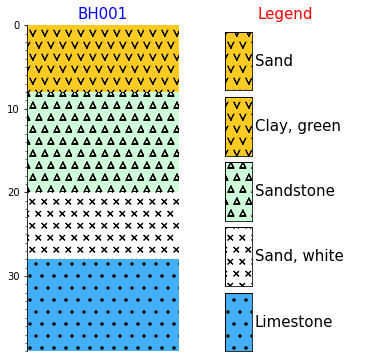

In [25]:
p.boreholes_3d[0].plot2d()

In [26]:
p.boreholes_3d[0].plot3d()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [27]:
p.boreholes_3d[0].plot3d(x3d=True)

### Display project boreholes

In [ ]:
p.plot3d(labels_size=15, bg_color=["royalblue", "aliceblue"], window_size=(1300, 1000))

199


### Boreholes in 3D using X3D for interaction within the notebook